# Algorithmic Customer Segmentation of Steam Users by Reviewing Behavior

Before beginning any analysis, we will first import the libraries we plan on using. In addition to the common python libraries pandas, numpy, matplotlib and seaborn, we will use scikit-learn to perform a clustering algorithm. I will detail why HDBSCAN was chosen later in the notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import HDBSCAN

## Our Problem


Imagine that we are product managers for Steam, the popular digital game distribution platform. Taking inspiration from platforms like Yelp, we are considering expanding our existing user review feature to give certain, high quality reviewers the distinction of "Elite Reviewers," so that users can know that certain reviews come from a more trusted source. 

To do this, we want to perform a segmentation on Steam's user data, specifically as it pertains to reviewing behavior. To plan our approach, I will outline both the goals we want to achieve and constraints that we must overcome:

#### Goals:
* We want our "Elite" reviewers to write ***high quality reviews***, so that "Elite" status will be appreciated by both the reviewers and users reading the reviews (we will define how we measure quality later).

* We want our "Elite" reviewers to write ***a high quantity of reviews***, so that their reviews populate the platform quickly.

* We want to leave the door open to ***analyzing other common factors of high quality reviewers,*** so we can further develop an understanding of how users interact with the feature.

#### Constraints:
* "Elite Reviewers" need to be ***active users and writers of reviews.*** - a reviewer does us no good if they are not writing anymore.

* There should be a ***minimum threshold of reviews*** for a user to be considered for this feature.

* "Elite Reviewers" should ***write high quality reviews > 50% of the time.*** 

* Since this is the platform's first time with an "Elite Reviewer" program, we want to ***pilot it with a small number of users*** before scaling up. To do this, we want to ensure that we are only giving this distinction to < 1% of the review writing population.


## Our Approach

### Summarized Gameplan:

1. Calculate the statistics needed from above
2. Filter our dataset
3. Transform our data
3. Run clustering algorithm
4. Analyze results

Most of these goals and constraints can be met simply by aggregating data already present in our dataset, as follows:

<br>

* **Average Review Quality &mdash;** There is no objective way to measure review quality, but Steam already has a feature that lets individual users identify if they found a review helpful or not. We will find the average number of "helpful" ratings given to a user's reviews by taking the mean of the **helpful** column in **recommendations.csv** for all reviews with the same **user_id**. We will call this value **avg_helpful**, and use it as a proxy for the quality of a user's reviews.

* **Total Review Quantity &mdash;** Conveniently, this value already exists in our data as **reviews** in **users.csv**! We will use it both as a value we are seeking to maximize, and as a filtering device by setting a minimum **reviews** requirement.

* **Review Activity &mdash;** To ensure our users are active, we can use the **date** column in **recommendations.csv**. We will check if they have written a reviews in the past 6 months (since 06-31-22 for this dataset) by looking at the maximum **date** for each **user_id**. We will also find the minimum of **date**, so we can check that a user has been writing reviews for longer than 6 months.  We will call these values **latest_review** and **earliest_review** respectively.

* **Median Review Quality &mdash;** We can verify that over 50% of a users reviews are "high quality" by checking that the median **helpful** value for reviews under a **user_id** is > 0. Because individual reviews have the potential to go "viral" and get a high number of **helpful** ratings, a small number of reviews with high ratings can skew the mean helpfulness level to the right for a user, meaning we cannot rely on the **avg_helpful** we are already calculating. 

<br>

These statistics nicely address many of our goals and constraints, but we still have a couple of more abstract ones that will require our creativity: 


#### Goals:
* ~~We want our "Elite" reviewers to write ***high quality reviews***, so that "Elite" status will be appreciated by both the reviewers and users reading the reviews (we will define how we measure quality later).~~
* ~~We want our "Elite" reviewers to write ***a high quantity of reviews***, so that their reviews populate the platform quickly.~~
* We want to leave the door open to ***analyzing other common factors of high quality reviewers,*** so we can further develop an understanding of how users interact with the feature.

<br>

#### Constraints:
* ~~"Elite Reviewers" need to be ***active users and writers of reviews.*** - a reviewer does us no good if they are not writing anymore.~~
* ~~There should be a ***minimum threshold of reviews*** for a user to be considered for this feature.~~
* ~~"Elite Reviewers" should ***write high quality reviews > 50% of the time.***~~
* Since this is the platform's first time with an "Elite Reviewer" program, we want to ***pilot it with a small number of users*** before scaling up. To do this, we want to ensure that we are only giving this distinction to < 1% of the review writing population.

<br>

We do have sufficient statistics available to filter our dataset significantly, which will help achieve our constraint of **a small number of users**, but simply setting arbitrary benchmarks for users to meet does not give us meaningful insight into what makes an ideal "Elite Reviewer." To better meet our goal of increasing future avenues of analysis, we can use clustering algorithms to find groups of our users that have similar qualities. This has a few advantages over the flat cutoff method:

<br>

* We can track performance and behavior of "Elite Reviewers" with similar qualities by subdividing them into groups, as opposed to looking at them as a monolith.
* We can take easily different numbers of variables into consideration when forming our clusters - for instance, if we later discovered that the number of **mac** only games reviewed by a user had an important effect on other variables, we could quickly rerun the analysis.
* If there was a massive change in our data- for example, a surge in reviews - we could more easily identify if it is global or local in scope by examining its effect on different clusters.

<br>

For these reasons, we will select our "Elite Reviewers" through an algorithmic clustering method. For reasons to be expanded upon later, I have chosen to use Hierarchical Density-Based Spatial Clustering of Applications with Noise&mdash;HDBSCAN. 

In the interest of opening doors to future analysis, we will also calculate some other statistics that have an ambiguous, but potentially interesting relationship to review writing behavior:

<br>

* **Average (Normalized) Review Playtime &mdash;** Does playing a game more before reviewing it make the review "better?" There are logical arguments in either direction, so it could be an interesting avenue for analysis. However, for this statistic to be meaningful, it must first be normalized with respect to the mean user playtime for each game, because some games are meant to be played for longer than others. Thus, we will calculate the standard deviation and mean of **hours** for reviews sharing an **app_id**, and then use it to calculate the z-score of **hours** for each review. Taking the mean z-score for each **user_id**, we get a normalized average playtime, which we call **avg_normalized_playtime.**


* **Review Positivity--** Depending on our business goals, we may want to ensure our "Elite Reviewers" write more or fewer positive reviews on average. We will calculate this simply by dividing the number of positive reviews (where **is_recommended** == True) for each user by the total number of reviews for that same user, and calling the value **proportion_pos_reviews.**


* **Review Impact--** Not all reviews are equally likely to be seen by users; some games are more popular than others, which can lead to their store pages being visited more frequently, which leads to reviews for those titles to have more opportunities to be seen. We may want to take into account how likely a review is to be seen by another user when selecting our "Elite Reviewers." We do not have a means to measure review visibility directly, but we can use the total **user_reviews** on each corresponding game (**app_id**) as a proxy for that game's popularity. By taking the mean of **user_reviews** for all games reviewed by a single **user_id**, we can estimate how much a reviewer contributes to "popular" games. 



## Our Data
Our data is sourced from the "Game Recommendations on Steam" dataset published by Anton Kozyriev on Kaggle. You can view it here: https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam.

The dataset features data for all users, reviews, and games on Steam as of December 31, 2022. 

The relevant tabular data is contained in the files **users.csv**, **recommendations.csv**, and **games.csv**, which should accompany this notebook. 

To begin our investigation, we will store the raw data of all games, users, and recommendations into pandas DataFrames so that we can readily manipulate them.

In [2]:
users_raw = pd.read_csv("users.csv")
recs_raw = pd.read_csv("recommendations.csv")
games_raw = pd.read_csv("games.csv")

Before manipulating our data, let us get a better idea of its scope:

In [3]:
print("User Info:\n")
print(users_raw.info())
print("\n")
print("Review Info:\n")
print(recs_raw.info())
print("\n")
print("Game Info:\n")
print(games_raw.info())
print("\n")

User Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14306064 entries, 0 to 14306063
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   products  int64
 2   reviews   int64
dtypes: int64(3)
memory usage: 327.4 MB
None


Review Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
dtypes: bool(1), float64(1), int64(5), object(1)
memory usage: 2.2+ GB
None


Game Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id    

As you can see, there are over 14 million unique Steam users, and over 41 million game reviews on the platform. Such a large dataset will make many calculations difficult, so it is in our interests to filter it when we can. 


## Steps 1 and 2: Calculating new fields and Filtering our data

We will handle both of these steps in parallel, as it is more efficient: rather than aggregating all variables from the entire dataset, we can aggregate only over the ones we know are relevant.


### Filtering out users with too few reviews

To begin with, we can filter with the already available **reviews** count for each user. Only users with a relatively high review volume will be eligible for "Elite Reviewer" status, so we will arbitrarily restrict consideration to users with more than 30 reviews.

In [4]:
# Filter pandas DataFrame
users_with_reviews = users_raw[users_raw["reviews"] >= 30]

#Check that we have fewer users now
print("Number of users with reviews: ")
print(users_with_reviews["user_id"].count())

Number of users with reviews: 
101552


We have gone from over 14 million users to just over 101 thousand! This just goes to show how rare review writing is already on Steam. 


### Calculating normalized_playtime for Recommendations

This is our variable representing how much more (or fewer) hours than averagae a user plays on a game before writing a review. To calculate it, we need to know the average and standard deviation of playtime for each game, so we will group **recs_raw** by **app_id**, calculate the mean playtime for each game, and then merge the data into **games_raw**:

In [5]:
# Group recs by game id
recs_grouped_by_game =  recs_raw.groupby("app_id")
# Calculate average and standard deviation of playtime for each game
avg_hours_of_games = recs_grouped_by_game.agg(avg_hours_played=pd.NamedAgg("hours", aggfunc="mean"), stdev_hours_played=pd.NamedAgg("hours", aggfunc="std"))

#Verify the data was aggregated
print(avg_hours_of_games.info())
print(avg_hours_of_games.head())

# Merge back into raw games data

games_with_avg_hours =pd.merge(games_raw, avg_hours_of_games, how="inner", on="app_id")

#Verify merge worked correctly
print(games_with_avg_hours.head()) 

<class 'pandas.core.frame.DataFrame'>
Index: 37610 entries, 10 to 2253290
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   avg_hours_played    37610 non-null  float64
 1   stdev_hours_played  37319 non-null  float64
dtypes: float64(2)
memory usage: 881.5 KB
None
        avg_hours_played  stdev_hours_played
app_id                                      
10            245.776802          284.728971
20             35.180766          117.164821
30             78.345194          177.226374
40             29.885466          121.491080
50             18.470209           56.536766
   app_id                              title date_release   win    mac  linux  \
0   13500  Prince of Persia: Warrior Within™   2008-11-21  True  False  False   
1  113020       Monaco: What's Yours Is Mine   2013-04-24  True   True   True   
2  226560                 Escape Dead Island   2014-11-18  True  False  False   
3  249050   

Now, we merge the average and standard deviation we just calculated into our **recs_raw** DataFrame, so that we can calculate a new field for **normalized_playtime**. 

In [6]:
# Merge the game data and rec data - we use inner merge so that only games with reviews get added, preventing NaN values
recs_with_avg_hours = pd.merge(recs_raw, games_with_avg_hours[["app_id", "avg_hours_played", "stdev_hours_played"]], how="inner", on="app_id")
#Verify merge worked
print(recs_with_avg_hours.head())

#Create a new calculated field for normalized_playtime - take difference of the sample playtime and mean playtime, then divide by the sample standard deviation
recs_with_avg_hours["normalized_playtime"] = (recs_with_avg_hours["hours"] - recs_with_avg_hours["avg_hours_played"])/recs_with_avg_hours["stdev_hours_played"]
#Verify calculated field was added successfully
print(recs_with_avg_hours.head())

   app_id  helpful  funny        date  is_recommended  hours   user_id  \
0  975370        0      0  2022-12-12            True   36.3     51580   
1  975370        0      0  2022-12-22            True   24.3  12159611   
2  975370        3      0  2022-12-07            True  177.0  11202425   
3  975370        5      0  2022-12-12            True  388.6   8779446   
4  975370        0      0  2022-12-07            True   70.1  12904124   

   review_id  avg_hours_played  stdev_hours_played  
0          0         72.793536          101.869311  
1        226         72.793536          101.869311  
2        316         72.793536          101.869311  
3       1182         72.793536          101.869311  
4       1346         72.793536          101.869311  
   app_id  helpful  funny        date  is_recommended  hours   user_id  \
0  975370        0      0  2022-12-12            True   36.3     51580   
1  975370        0      0  2022-12-22            True   24.3  12159611   
2  975370      

### Calculating latest_review, earliest_review, and median_helpful for Users

There are a couple more filtrations that we know we will want: 
* We know we want to filter users by the **date** of their most recent and first ever reviews
* We want to filter out any users whose median **helpful** rating is 0, since we are interested in consistency

To better filter our data, let's aggregate these metrics first.

First, let's join the user data and review data through a left join. This will ensure that only the users in **users_with_reviews** get their reviews merged into the new dataframe.

In [7]:
#Merge the rec info into the user info - we use left join to preserve the order of users_with_reviews
joined_users_recs = pd.merge(users_with_reviews, recs_with_avg_hours, how="left", on="user_id")
#Verify the merge worked
print(joined_users_recs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5828800 entries, 0 to 5828799
Data columns (total 13 columns):
 #   Column               Dtype  
---  ------               -----  
 0   user_id              int64  
 1   products             int64  
 2   reviews              int64  
 3   app_id               int64  
 4   helpful              int64  
 5   funny                int64  
 6   date                 object 
 7   is_recommended       bool   
 8   hours                float64
 9   review_id            int64  
 10  avg_hours_played     float64
 11  stdev_hours_played   float64
 12  normalized_playtime  float64
dtypes: bool(1), float64(4), int64(7), object(1)
memory usage: 539.2+ MB
None


There are several columns in the recommendations DataFrame that we will not be using (the **hours**, **avg_hours_played**, and **stdev_hours_played** columns we are done using, as well as the **funny** and **review_id** columns), so we will remove those.

In [8]:
# Select only columns we still need for our analysis
joined_users_recs_trimmed = joined_users_recs[["user_id", "products", "reviews", "app_id", "helpful", "normalized_playtime", "date", "is_recommended"]]

# verify the correct columns appear
print(joined_users_recs_trimmed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5828800 entries, 0 to 5828799
Data columns (total 8 columns):
 #   Column               Dtype  
---  ------               -----  
 0   user_id              int64  
 1   products             int64  
 2   reviews              int64  
 3   app_id               int64  
 4   helpful              int64  
 5   normalized_playtime  float64
 6   date                 object 
 7   is_recommended       bool   
dtypes: bool(1), float64(1), int64(5), object(1)
memory usage: 316.9+ MB
None


Now, we will group the recommendations by **user_id.**

In [9]:

# Group by user_id
grouped_recs = joined_users_recs.groupby("user_id")

#Verify merge worked
print(grouped_recs.head())
#Count groups - it should match the number of users from earlier
print(len(grouped_recs.groups.keys()))

         user_id  products  reviews   app_id  helpful  funny        date  \
0        4616950       702       36   250900        0      0  2017-02-17   
1        4616950       702       36   239030        0      0  2013-12-12   
2        4616950       702       36   264710        0      2  2018-05-30   
3        4616950       702       36  1092790        0      0  2022-11-22   
4        4616950       702       36   335300        2      0  2017-01-01   
...          ...       ...      ...      ...      ...    ...         ...   
5828720  4156581       367       80  1172620       14      4  2022-04-19   
5828721  4156581       367       80   534380        3      0  2022-05-07   
5828722  4156581       367       80  1172470      418     39  2022-05-08   
5828723  4156581       367       80   218620        8      0  2022-04-19   
5828724  4156581       367       80   578080       16      3  2022-04-21   

         is_recommended  hours  review_id  avg_hours_played  \
0                  True 

Next, we perform the aggregation using pandas DataFrame.agg(). *Note: We will need to aggregate these values again after we've filtered.*

In [10]:

# Find the min and max of date to represent the first and last reviews written by the user, and the median of "helpful" so we can identity users with >50% reviews that are helpful 
users_by_date_and_median_helpful = grouped_recs.agg({"date":["min", "max"], "helpful":"median"})

# Test that our columns were aggregated correctly.
print(users_by_date_and_median_helpful.info())
print(users_by_date_and_median_helpful.head())

<class 'pandas.core.frame.DataFrame'>
Index: 101552 entries, 257 to 14305966
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   (date, min)        101552 non-null  object 
 1   (date, max)        101552 non-null  object 
 2   (helpful, median)  101552 non-null  float64
dtypes: float64(1), object(2)
memory usage: 7.1+ MB
None
               date             helpful
                min         max  median
user_id                                
257      2014-05-27  2021-01-08     0.0
464      2014-04-03  2022-06-08     2.0
519      2017-08-28  2022-05-21     0.0
814      2014-08-28  2022-08-09     0.0
1072     2014-12-07  2017-06-06     8.5


### Filtering by Review Activity and Median Helpfulness

To filter for most recent review activity, let us only consider users whose most recent review is within past 6 months (our data extends to 2022-12-31, so we will consider "6 months ago" to be 2022-06-30).

In [11]:
#Select only users whose last review was in last 6 months
users_filtered_by_recent = users_by_date_and_median_helpful[users_by_date_and_median_helpful["date"]["max"] > "2022-06-30"]

# verify the filtration worked
print(users_filtered_by_recent.info())

<class 'pandas.core.frame.DataFrame'>
Index: 77450 entries, 814 to 14305792
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (date, min)        77450 non-null  object 
 1   (date, max)        77450 non-null  object 
 2   (helpful, median)  77450 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.4+ MB
None


Now, we will further filter the data by how long the user has been writing reviews - we will exclude any user whose first review is less than 6 months prior to their most recent review. 

In [12]:
#Select only users with a difference of 180 days or more between first review and last review
long_time_users = users_filtered_by_recent[(pd.to_datetime(users_filtered_by_recent["date"]["max"]) - pd.to_datetime(users_filtered_by_recent["date"]["min"])).dt.days >= 180]

# Verify the filtration worked
print(long_time_users.info())
print(long_time_users.head())

<class 'pandas.core.frame.DataFrame'>
Index: 77260 entries, 814 to 14305792
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (date, min)        77260 non-null  object 
 1   (date, max)        77260 non-null  object 
 2   (helpful, median)  77260 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.4+ MB
None
               date             helpful
                min         max  median
user_id                                
814      2014-08-28  2022-08-09     0.0
1209     2012-10-31  2022-08-14     0.0
1239     2019-08-15  2022-12-30    22.5
1519     2020-01-25  2022-12-25     0.0
1699     2015-04-13  2022-12-06     0.0


Lastly, we will filter by median **helpful** rating - we will only keep users with a median **helpful** > 0. This represents users that received at least one helpful rating on 50% or more of their reviews. 

In [13]:
# Filter by median "helpful" rating
filtered_users = long_time_users[long_time_users["helpful"]["median"] > 0]

# Verify that our data was filtered correctly
print(filtered_users.info())
print(filtered_users.head())

<class 'pandas.core.frame.DataFrame'>
Index: 14780 entries, 1239 to 14305792
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (date, min)        14780 non-null  object 
 1   (date, max)        14780 non-null  object 
 2   (helpful, median)  14780 non-null  float64
dtypes: float64(1), object(2)
memory usage: 461.9+ KB
None
               date             helpful
                min         max  median
user_id                                
1239     2019-08-15  2022-12-30    22.5
2601     2018-06-17  2022-12-27     2.0
2881     2019-05-17  2022-12-25     2.0
3629     2020-07-05  2022-12-30     5.0
4601     2012-12-15  2022-08-26     3.0


### Aggregating User info from Recs with Built-in functions

Since the number of users meeting our activity criteria has gotten significantly smaller, let's group our recommendations again with the filtered set of users:

In [14]:
#We use our filtered_users DataFrame to filter our joined_users_recs DataFrame
recs_filtered_by_activity = joined_users_recs[joined_users_recs["user_id"].isin(filtered_users.index)]

# Verify the filter worked
print("Info for Recs filtered by Activity: \n")
print(recs_filtered_by_activity.info(), "\n")

#We group the recs once again
filtered_grouped_recs = recs_filtered_by_activity.groupby("user_id")

#Verify  the group operation worked
print("Info for filtered, grouped Recs:\n")
print(filtered_grouped_recs.head(), "\n")

#Count the number of groups - it should equal the number of users
print("Number of groups:\n")
print(len(filtered_grouped_recs.groups.keys()))


Info for Recs filtered by Activity: 

<class 'pandas.core.frame.DataFrame'>
Index: 1135272 entries, 176 to 5828604
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   user_id              1135272 non-null  int64  
 1   products             1135272 non-null  int64  
 2   reviews              1135272 non-null  int64  
 3   app_id               1135272 non-null  int64  
 4   helpful              1135272 non-null  int64  
 5   funny                1135272 non-null  int64  
 6   date                 1135272 non-null  object 
 7   is_recommended       1135272 non-null  bool   
 8   hours                1135272 non-null  float64
 9   review_id            1135272 non-null  int64  
 10  avg_hours_played     1135272 non-null  float64
 11  stdev_hours_played   1135219 non-null  float64
 12  normalized_playtime  1135168 non-null  float64
dtypes: bool(1), float64(4), int64(7), object(1)
memory usage: 113.7+ MB

We're down to just under 15 thousand users meeting our criteria so far. At this point, we are going to stop filtering and simply aggregate the user info we need for our clustering analysis.

We will use the PANDAS NamedAgg feature to aggregate several of our metrics at once, including the ones we used in our earlier filtering. As a recap, they are:

* Number of Products, saved as **products** - This is the same for all of a user's reviews, so we can use the "max" function
* Number of Reviews, saved as **reviews** - We will use the "count" function 
* Average (Normalized) Review Playtime, saved as **avg_normalized_playtime** - We will use the "mean" function
* Average Helpfulness, saved as **avg_helpful** - We will use the "mean" function
* Median Helpfulness, saved as **median_helpful** - We will use the "median" function
* Earliest Review, saved as **earliest_review** - We will use the "min" function
* Latest Review, saved as **latest_review** - We will use the "max" function

In [15]:
# Aggregate our grouped data into a single dataframe, naming the columns
agg_user_info = filtered_grouped_recs.agg(products=pd.NamedAgg("products", aggfunc="max"), 
                                          reviews=pd.NamedAgg("reviews", aggfunc="count"), 
                                          avg_helpful=pd.NamedAgg("helpful", aggfunc="mean"), 
                                          median_helpful=pd.NamedAgg("helpful", aggfunc="median"),
                                          avg_normalized_playtime=pd.NamedAgg("normalized_playtime", aggfunc="mean"),
                                          earliest_review=pd.NamedAgg("date", aggfunc="min"),
                                          latest_review=pd.NamedAgg("date", aggfunc="max") 
                                          )

#Test that our columns were aggregated correctly
print(agg_user_info.info())

<class 'pandas.core.frame.DataFrame'>
Index: 14780 entries, 1239 to 14305792
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   products                 14780 non-null  int64  
 1   reviews                  14780 non-null  int64  
 2   avg_helpful              14780 non-null  float64
 3   median_helpful           14780 non-null  float64
 4   avg_normalized_playtime  14778 non-null  float64
 5   earliest_review          14780 non-null  object 
 6   latest_review            14780 non-null  object 
dtypes: float64(3), int64(2), object(2)
memory usage: 1.4+ MB
None


### Aggregating Review Positivity and Review Impact with User Defined Functions

There are still two metrics that we need to aggregate: Review Positivity, and Review Impact. There are no built-in functions for these, so we will have to write user-defined functions.

Below, we define a function that will let us count the number of "True" boolean values in a list. We will use this to count the number of cases where **is_recommended** is True for a user's reviews.

In [16]:
# A function that takes a group, iterates over it, and for every value that is "True", will increment by one, then return the result

def count_true(group):
    truth_count = 0
    for x in group:
            if x == True:
                truth_count = truth_count + 1
    return truth_count

# Test our function
print("Number of True values in list [True, False, True, True]:")
print(count_true([True, False, True, True]))
print("Number of True values in list [True, False, True, False]:")
print(count_true([True, False, True, False]))

Number of True values in list [True, False, True, True]:
3
Number of True values in list [True, False, True, False]:
2


Now we use our new function to aggregate data from the **is_recommended** column.

In [17]:
# Return our aggregated count of positive recs as a Series
pos_recs_per_user = filtered_grouped_recs["is_recommended"].agg(lambda x: count_true(x))

# Verify the Series was created correctly
print(pos_recs_per_user.head())

user_id
1239    341
2601     30
2881    181
3629    126
4601     28
Name: is_recommended, dtype: int64


In [18]:
#Merge our new Series into agg_user_info
agg_user_info_positivity = agg_user_info.merge(pos_recs_per_user, how="left", on="user_id")

# Verify the Series was successfully added as a column
print(agg_user_info_positivity.head())


         products  reviews  avg_helpful  median_helpful  \
user_id                                                   
1239         1301      346    34.852601            22.5   
2601          440       31     4.129032             2.0   
2881          464      183    12.923497             2.0   
3629          523      152     9.078947             5.0   
4601         8092       35     4.971429             3.0   

         avg_normalized_playtime earliest_review latest_review  is_recommended  
user_id                                                                         
1239                   -0.217045      2019-08-15    2022-12-30             341  
2601                   -0.078400      2018-06-17    2022-12-27              30  
2881                    1.405728      2019-05-17    2022-12-25             181  
3629                   -0.164980      2020-07-05    2022-12-30             126  
4601                   -0.010269      2012-12-15    2022-08-26              28  


Now that we know the count of how many postive reviews each reviewer has made, we can calculate the proportion of their reviews that are postive by dividing **is_recomended** by **reviews**.

In [19]:
# Create a new calculated column from "is_recommended" and "reviews"
agg_user_info_positivity["proportion_pos_reviews"] = agg_user_info_positivity["is_recommended"]*1.0/agg_user_info_positivity["reviews"]

# Confirm that the column was added correctly
print(agg_user_info_positivity.head())

         products  reviews  avg_helpful  median_helpful  \
user_id                                                   
1239         1301      346    34.852601            22.5   
2601          440       31     4.129032             2.0   
2881          464      183    12.923497             2.0   
3629          523      152     9.078947             5.0   
4601         8092       35     4.971429             3.0   

         avg_normalized_playtime earliest_review latest_review  \
user_id                                                          
1239                   -0.217045      2019-08-15    2022-12-30   
2601                   -0.078400      2018-06-17    2022-12-27   
2881                    1.405728      2019-05-17    2022-12-25   
3629                   -0.164980      2020-07-05    2022-12-30   
4601                   -0.010269      2012-12-15    2022-08-26   

         is_recommended  proportion_pos_reviews  
user_id                                          
1239                341

We will also define a function to calculate what we will call a "visibility score" - it is the mean number of reviews of each game that has been reviewed by a user. This is supposed to give an indicator of how much traffic each review written by a user is likely to receive.

In [20]:
#Looks up all of the games in a group, and then returns the mean of their number of reviews
def average_visibility_score(group):
    return games_raw[games_raw["app_id"].isin(group)]["user_reviews"].mean()

# test our function
print(average_visibility_score(filtered_grouped_recs.get_group(1239)["app_id"]))

41061.61849710983


In [21]:
# Use Series.agg to pass in our UDF and get a series of visibility scores
visibility_score = filtered_grouped_recs["app_id"].agg(lambda x: average_visibility_score(x))

#Verify the aggregation worked
print(visibility_score.head())

user_id
1239     41061.618497
2601    446499.000000
2881     72664.409836
3629     55908.355263
4601     63071.657143
Name: app_id, dtype: float64


In [22]:
# merge visibility score Series into user info
agg_user_info_positivity_visibility = agg_user_info_positivity.merge(visibility_score, how="left", on="user_id")
#Rename column to "visibility_score" to avoid confusion
agg_user_info_positivity_visibility.rename({"app_id":"visibility_score"}, axis="columns", inplace=True)
#Verify column was added successfully
print(agg_user_info_positivity_visibility.head())

         products  reviews  avg_helpful  median_helpful  \
user_id                                                   
1239         1301      346    34.852601            22.5   
2601          440       31     4.129032             2.0   
2881          464      183    12.923497             2.0   
3629          523      152     9.078947             5.0   
4601         8092       35     4.971429             3.0   

         avg_normalized_playtime earliest_review latest_review  \
user_id                                                          
1239                   -0.217045      2019-08-15    2022-12-30   
2601                   -0.078400      2018-06-17    2022-12-27   
2881                    1.405728      2019-05-17    2022-12-25   
3629                   -0.164980      2020-07-05    2022-12-30   
4601                   -0.010269      2012-12-15    2022-08-26   

         is_recommended  proportion_pos_reviews  visibility_score  
user_id                                                

We nearly have our final DataFrame! For the sake of neatness, let's reorder the columns so that our Timestamp data is on the last two columns:

In [23]:
#Same columns, different order
final_user_info = agg_user_info_positivity_visibility[["products", "reviews", "avg_helpful", "median_helpful", "is_recommended", "proportion_pos_reviews", "avg_normalized_playtime", "visibility_score", "earliest_review", "latest_review"]]
# reset index for consistency
final_user_info.reset_index(inplace=True)

#Verify the user info looks correct
print(final_user_info.info())
print(final_user_info.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14780 entries, 0 to 14779
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  14780 non-null  int64  
 1   products                 14780 non-null  int64  
 2   reviews                  14780 non-null  int64  
 3   avg_helpful              14780 non-null  float64
 4   median_helpful           14780 non-null  float64
 5   is_recommended           14780 non-null  int64  
 6   proportion_pos_reviews   14780 non-null  float64
 7   avg_normalized_playtime  14778 non-null  float64
 8   visibility_score         14780 non-null  float64
 9   earliest_review          14780 non-null  object 
 10  latest_review            14780 non-null  object 
dtypes: float64(5), int64(4), object(2)
memory usage: 1.2+ MB
None
   user_id  products  reviews  avg_helpful  median_helpful  is_recommended  \
0     1239      1301      346    34.852601  

## Step 3: Transforming our data


### Summary of rationale for transformation

Detailed explanation of how I reached this conclusion is in the following section.

* Our data is highly variable in range
* Our data is highly variable in density - the data is astronomically denser closer to the origin.
* Some variables have drastically different scale than others
* The points we are most interested in are the ones furthest from the origin, and therefore in the least dense area

This  presents a challenge for our clustering analysis - because the scale of our data is so dispersed, many of the points in the lower left corner of the "L" are relatively closer to each other than to the ends of the "L". This makes it difficult to identify clear subsets of the data in the center not only visually, but also with clustering algorithms.

To circumvent this, we will try transforming our data.



### Visualizing the distribution of our key Variables (reviews & avg_helpful)

There are many variables for us to analyze in our dataset, but to give an idea of its overall distribution and some of the challenges posed, we will first visualize just our two most important variables: **reviews** and **avg_helpful**, which represent review quantity and review quality, respectively. They are our most important because as per our Goals, we want to maximize them.

Text(0, 0.5, 'Average Helpful rating')

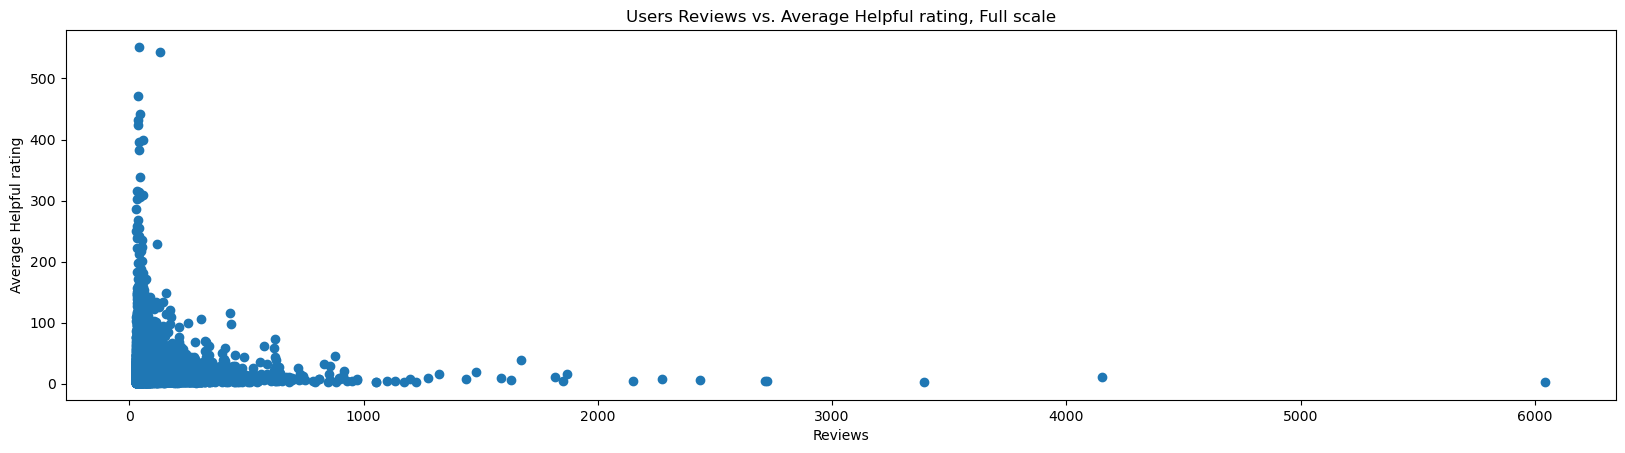

In [24]:
# Make a simple scatter plot
fig, ax = plt.subplots()
fig.set_figwidth(20)
ax.scatter(final_user_info["reviews"], final_user_info["avg_helpful"])
ax.set_title("Users Reviews vs. Average Helpful rating, Full scale")
ax.set_xlabel("Reviews")
ax.set_ylabel("Average Helpful rating")




Note that the data forms an "L" shape, with very long tails extending to the right and upward. This is representative of how each variable is skewed. This is expected behavior, because there is no upper limit to how many reviews a user can write, or how many times a review can be rated as helpful; consequently values can span several orders of magnitude. We can attempt to visualize more properly by exclusing some of the most severe outliers: 






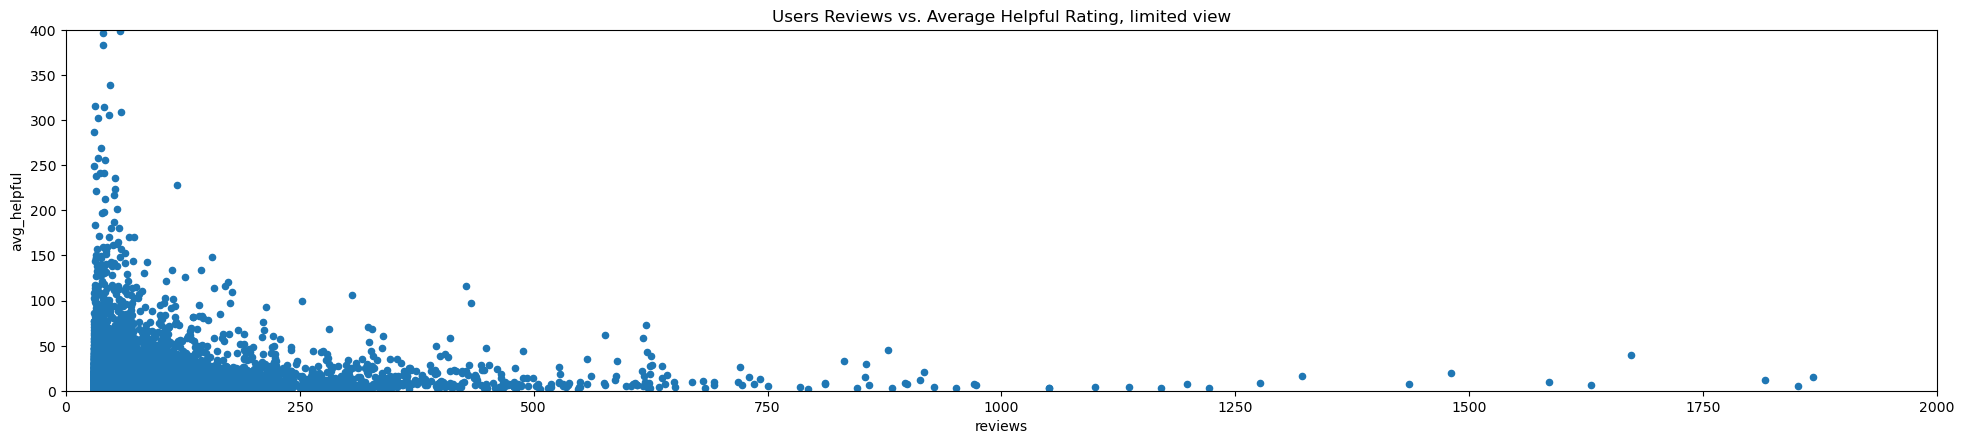

In [25]:
#Plot a second version with a limited view of the axes to allow for better visualization
ax = final_user_info.plot("reviews", "avg_helpful", kind="scatter")
ax.get_figure().set_figwidth(20)
ax.set
ax.set_xlim((0,2000))
ax.set_ylim((0,400))
ax.set_title("Users Reviews vs. Average Helpful Rating, limited view")
plt.tight_layout(pad = 2)
plt.show()

But even in this case, we cannot see exactly how many points lie close to 0, 0. Yet it cannot be stressed enough that the data is most dense on the left side of the graph, where **avg_helpful** and **reviews** approach 0. This fact is better seen through as histogram, which

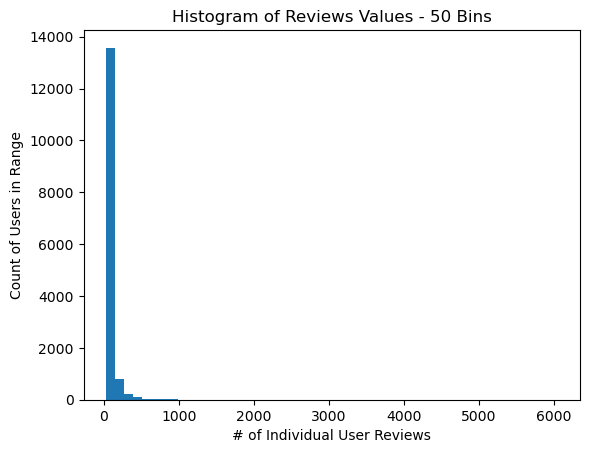

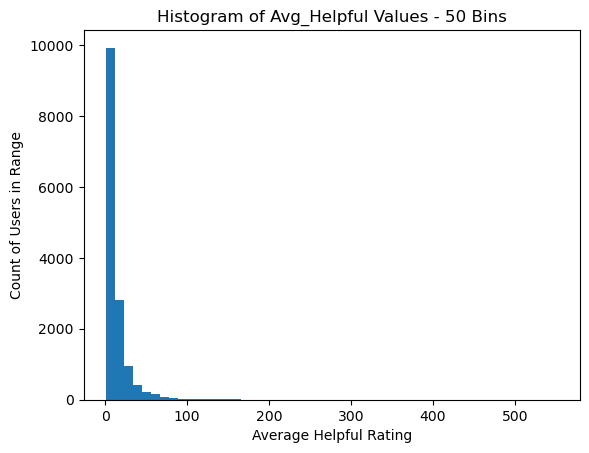

In [26]:
# Plot a histogram of reviews - each bar represents the frequency of reviews values in that range
plt.hist(final_user_info["reviews"], 50)
plt.title("Histogram of Reviews Values - 50 Bins")
plt.xlabel("# of Individual User Reviews")
plt.ylabel("Count of Users in Range")
plt.show()

#Plot a histogram of avg_helpful = each bar represents the frequency of avg_helpful values in that range
plt.hist(final_user_info["avg_helpful"], 50)
plt.title("Histogram of Avg_Helpful Values - 50 Bins")
plt.xlabel("Average Helpful Rating")
plt.ylabel("Count of Users in Range")
plt.show()

There are 14,780 users in this dataset; notice how for both **reviews** and **avg_helpful**, the majority of values fall in the very first bin, out of 100 total bins. This means that the lowest 1% of values in the range of these variables contains a supermajority of the observations. 

This presents an issue for our specific goals, because the users we are most interested in are those with higher values of **reviews** and **avg_helpful.** Yet those values are generally the ones most distant from other points, making it harder to see the relationships between them.

### Relationships to other Variables

Let's look at some of the other relationships to see if they provide any insight:

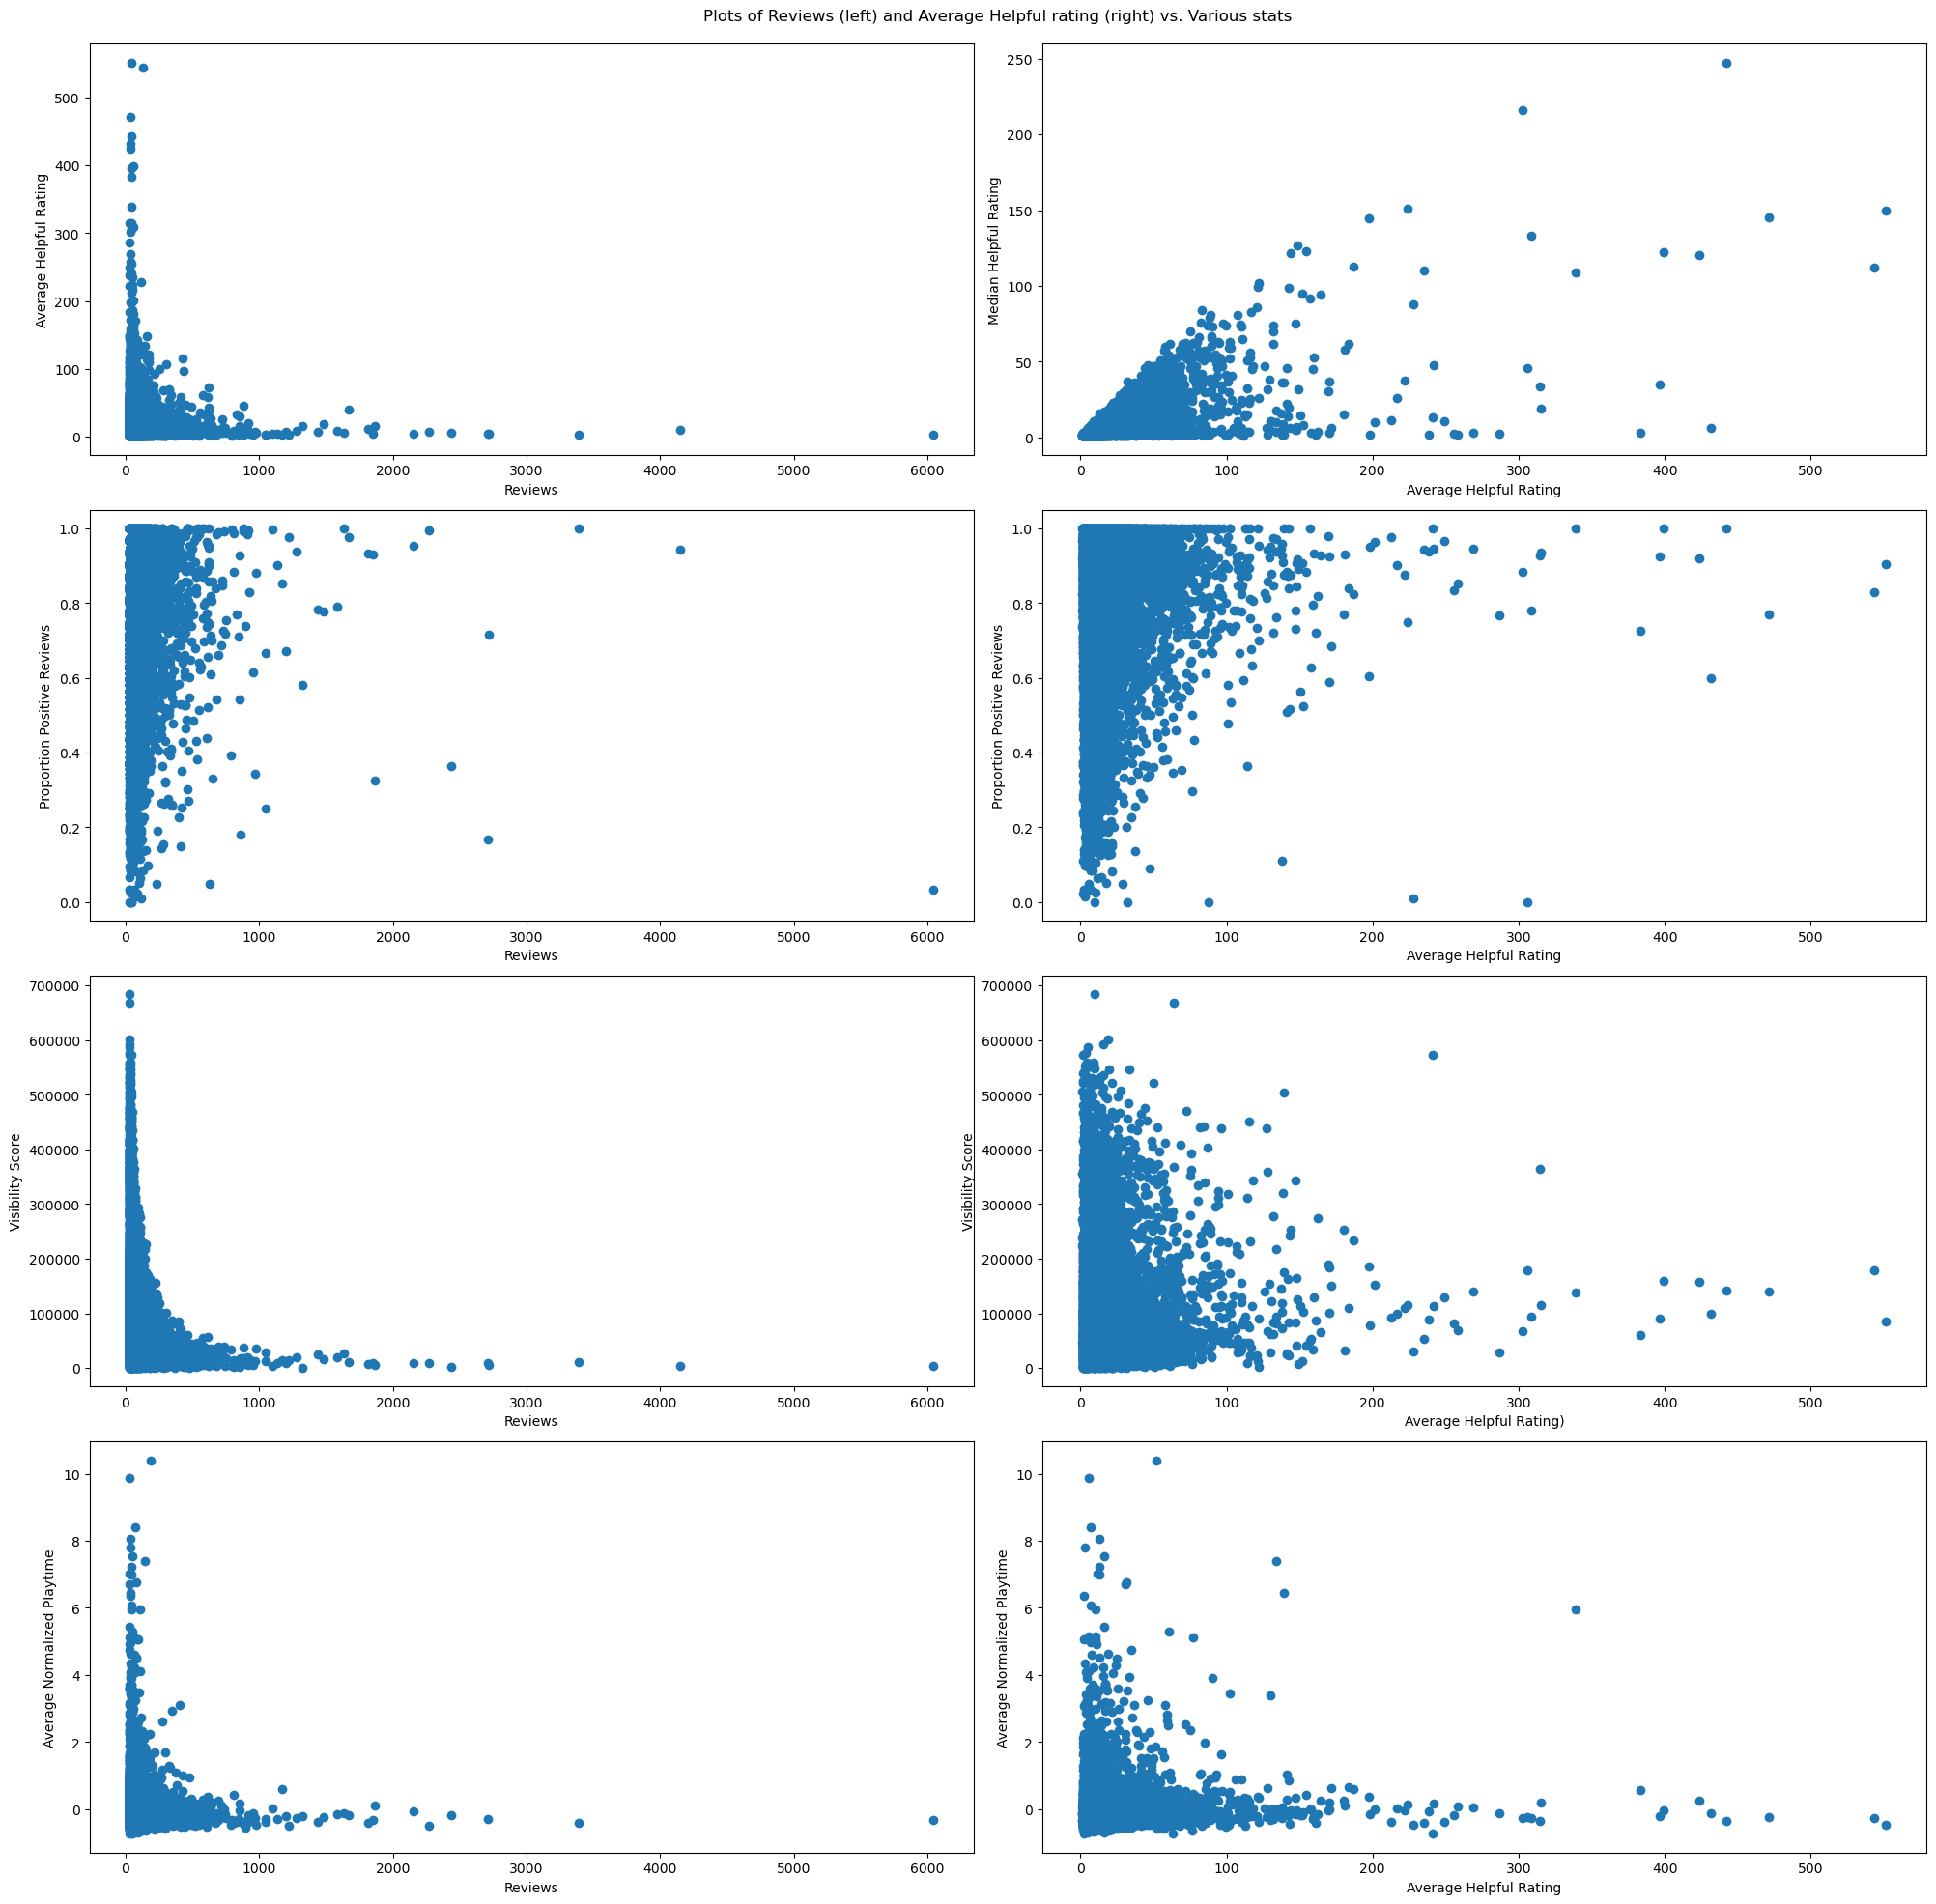

In [27]:
# Create a grid of subplots
fig, ax = plt.subplots(4, 2)
#Set figure size to make plots eye-friendly
fig.set_figwidth(20)
fig.set_figheight(20)

fig.suptitle("Plots of Reviews (left) and Average Helpful rating (right) vs. Various stats")
plt.tight_layout(pad=2)
# Plot relationships with other variables - Reviews on the left column, avg_helpful on the right
ax[0,0].scatter(final_user_info["reviews"], final_user_info["avg_helpful"])
ax[0,0].set_xlabel("Reviews")
ax[0,0].set_ylabel("Average Helpful Rating")
ax[1,0].scatter(final_user_info["reviews"], final_user_info["proportion_pos_reviews"])
ax[1,0].set_xlabel("Reviews")
ax[1,0].set_ylabel("Proportion Positive Reviews")
ax[2,0].scatter(final_user_info["reviews"], final_user_info["visibility_score"])
ax[2,0].set_xlabel("Reviews")
ax[2,0].set_ylabel("Visibility Score")
ax[3,0].scatter(final_user_info["reviews"], final_user_info["avg_normalized_playtime"])
ax[3,0].set_xlabel("Reviews")
ax[3,0].set_ylabel("Average Normalized Playtime")
ax[0,1].scatter(final_user_info["avg_helpful"], final_user_info["median_helpful"])
ax[0,1].set_xlabel("Average Helpful Rating")
ax[0,1].set_ylabel("Median Helpful Rating")
ax[1,1].scatter(final_user_info["avg_helpful"], final_user_info["proportion_pos_reviews"])
ax[1,1].set_xlabel("Average Helpful Rating")
ax[1,1].set_ylabel("Proportion Positive Reviews")
ax[2,1].scatter(final_user_info["avg_helpful"], final_user_info["visibility_score"])
ax[2,1].set_xlabel("Average Helpful Rating)")
ax[2,1].set_ylabel("Visibility Score")
ax[3,1].scatter(final_user_info["avg_helpful"], final_user_info["avg_normalized_playtime"])
ax[3,1].set_xlabel("Average Helpful Rating")
ax[3,1].set_ylabel("Average Normalized Playtime")
plt.show()

These relationships, while interesting, do not directly illuminate a path forward, because they also seem to have highly variable density. Part of the issue seems to lie in the vastly disparate scales of our variables - some span multiple orders of magnitude, **proportion_pos_reviews** is bound between 0 and 1, and **average_normalized** playtime is normalized. These factors combine to make higher dimensional clustering less reliable, as the distance metrics tend to balloon as dimensions increase, especially when variables have different scales.

Given all of these factors, we should transform our data to make it more friendly to distance-based clustering methods.

### Transforming our data

Since we want to both reduce the scale of our data and make its density more uniform, applying a natural logarithm function (np.log) to our values of **avg_helpful** and **reviews** could prove effective. The effect of the logarithm is to turn exponential differences into linear ones, so it can take the massive differences in scale and effectively bring them closer together.
**visibility_score** also spans a wide range of values, so for the sake of consistency in visualization, we will transform it. 

C:\Users\tdsul\AppData\Local\Temp\ipykernel_24332\651178079.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformed_user_info["reviews"] = transformed_reviews.apply(np.log)


   user_id  products  median_helpful  is_recommended  proportion_pos_reviews  \
0     1239      1301            22.5             341                0.985549   
1     2601       440             2.0              30                0.967742   
2     2881       464             2.0             181                0.989071   
3     3629       523             5.0             126                0.828947   
4     4601      8092             3.0              28                0.800000   

   avg_normalized_playtime  visibility_score earliest_review latest_review  \
0                -0.217045         10.622829      2019-08-15    2022-12-30   
1                -0.078400         13.009192      2018-06-17    2022-12-27   
2                 1.405728         11.193607      2019-05-17    2022-12-25   
3                -0.164980         10.931469      2020-07-05    2022-12-30   
4                -0.010269         11.052027      2012-12-15    2022-08-26   

    reviews  avg_helpful  
0  5.846439     3.55112

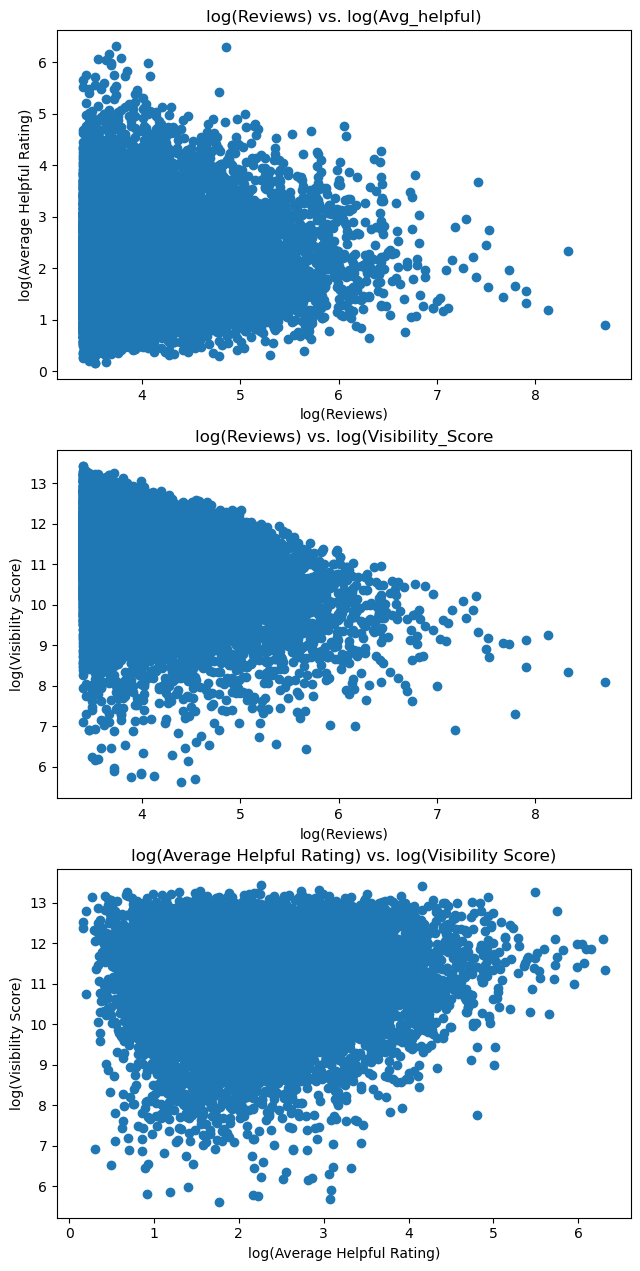

In [28]:
# Get Series from our user info DataFrame
transformed_reviews = final_user_info["reviews"]
transformed_avg_helpful = final_user_info["avg_helpful"]
transformed_visibility = final_user_info["visibility_score"]
transformed_user_info = final_user_info[["user_id", "products", "median_helpful", "is_recommended", "proportion_pos_reviews", "avg_normalized_playtime", "visibility_score", "earliest_review", "latest_review"]]

# Apply np.log to our large scaled variables
transformed_user_info["reviews"] = transformed_reviews.apply(np.log)
transformed_user_info["avg_helpful"] = transformed_avg_helpful.apply(np.log)
transformed_user_info["visibility_score"] = transformed_visibility.apply(np.log)

#Check that the logarithm was applied
print(transformed_user_info.head())
print(final_user_info.head())

#visualize our tranasformed variables
fig, ax = plt.subplots(3)
fig.set_figwidth(7)
fig.set_figheight(13)
fig.tight_layout(pad=3)
ax[0].scatter(transformed_user_info["reviews"], transformed_user_info["avg_helpful"])
ax[0].set_title("log(Reviews) vs. log(Avg_helpful)")
ax[0].set_xlabel("log(Reviews)")
ax[0].set_ylabel("log(Average Helpful Rating)")
ax[1].scatter(transformed_user_info["reviews"], transformed_user_info["visibility_score"])
ax[1].set_title("log(Reviews) vs. log(Visibility_Score")
ax[1].set_xlabel("log(Reviews)")
ax[1].set_ylabel("log(Visibility Score)")
ax[2].scatter(transformed_user_info["avg_helpful"], transformed_user_info["visibility_score"])
ax[2].set_title("log(Average Helpful Rating) vs. log(Visibility Score)")
ax[2].set_xlabel("log(Average Helpful Rating)")
ax[2].set_ylabel("log(Visibility Score)")
plt.show()

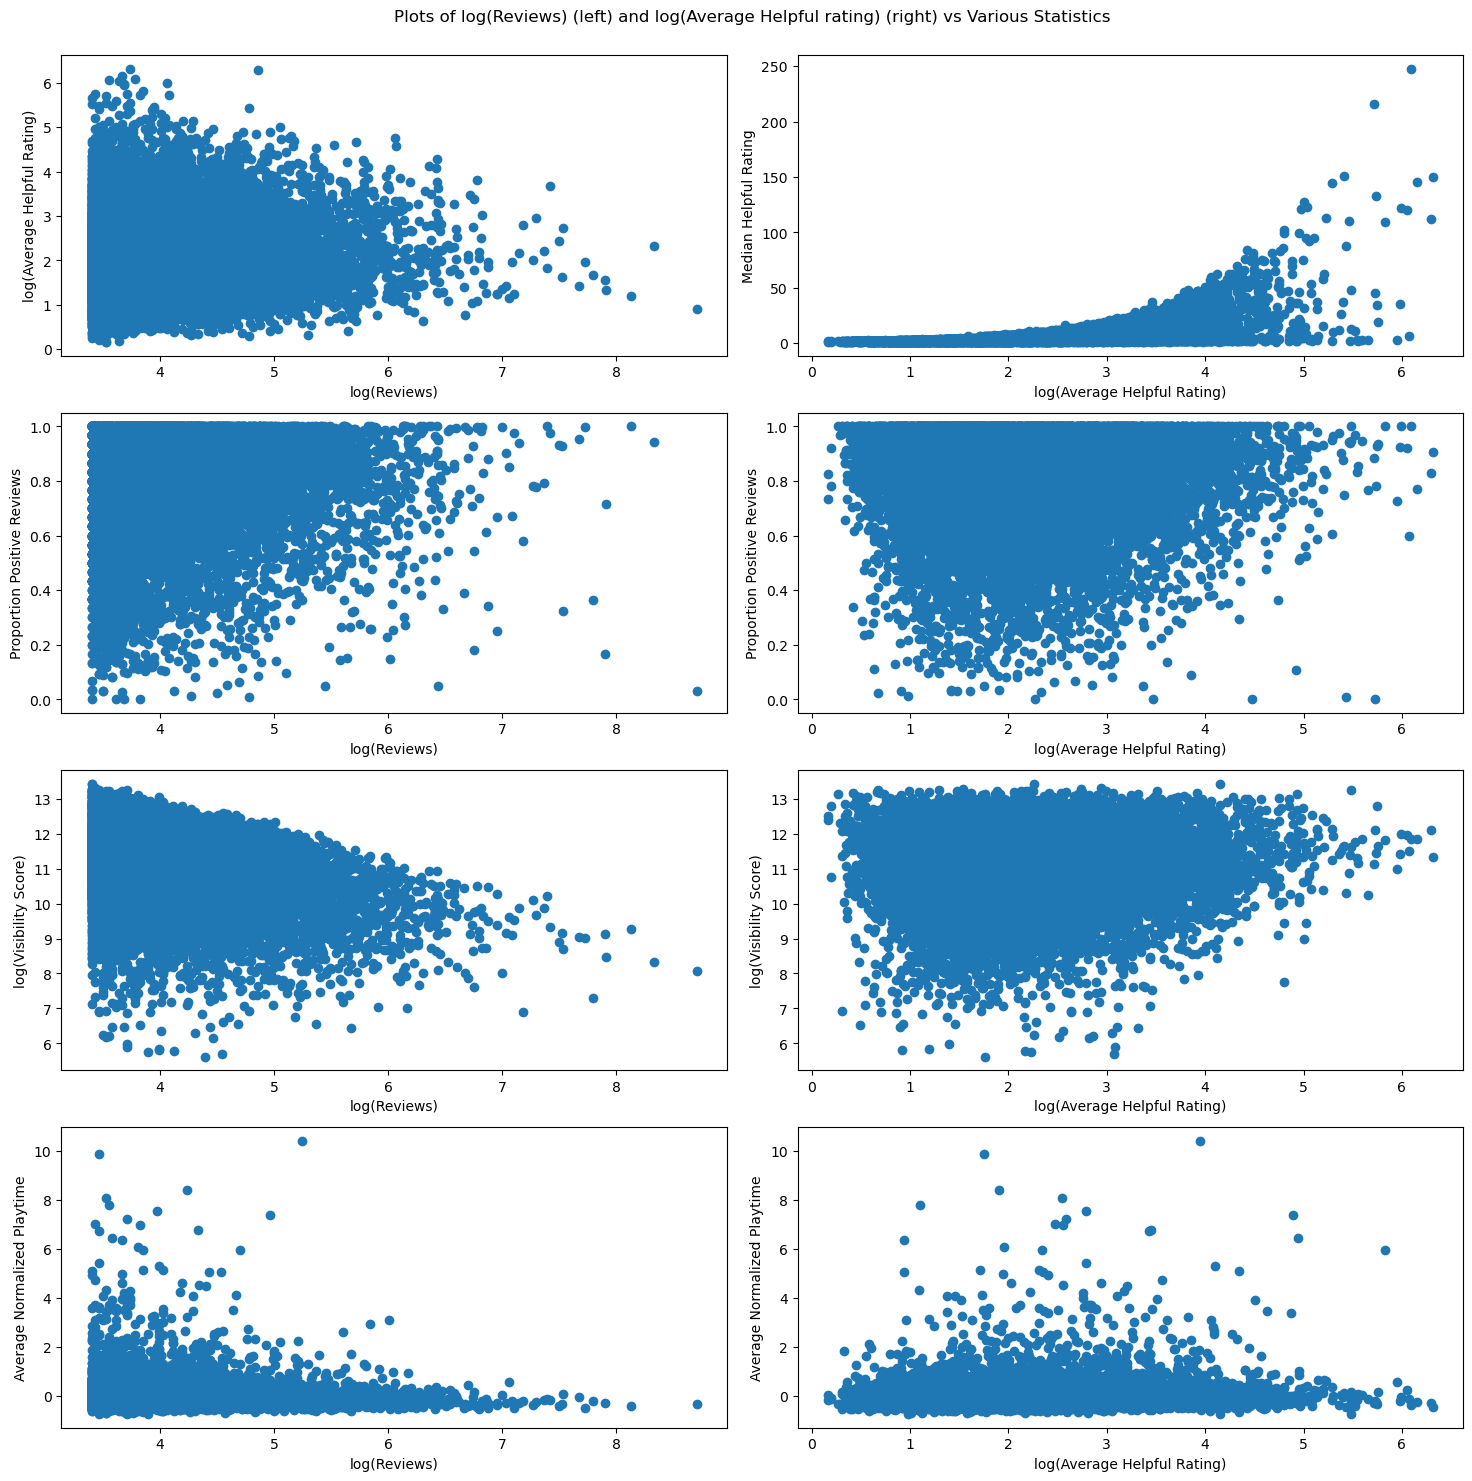

In [29]:
fig, ax = plt.subplots(4, 2)
fig.set_figwidth(15)
fig.set_figheight(15)
fig.suptitle("Plots of log(Reviews) (left) and log(Average Helpful rating) (right) vs Various Statistics")
plt.tight_layout(pad = 2)
ax[0,0].scatter(transformed_user_info["reviews"], transformed_user_info["avg_helpful"])
ax[0,0].set_xlabel("log(Reviews)")
ax[0,0].set_ylabel("log(Average Helpful Rating)")
ax[1,0].scatter(transformed_user_info["reviews"], transformed_user_info["proportion_pos_reviews"])
ax[1,0].set_xlabel("log(Reviews)")
ax[1,0].set_ylabel("Proportion Positive Reviews")
ax[2,0].scatter(transformed_user_info["reviews"], transformed_user_info["visibility_score"])
ax[2,0].set_xlabel("log(Reviews)")
ax[2,0].set_ylabel("log(Visibility Score)")
ax[3,0].scatter(transformed_user_info["reviews"], transformed_user_info["avg_normalized_playtime"])
ax[3,0].set_xlabel("log(Reviews)")
ax[3,0].set_ylabel("Average Normalized Playtime")
ax[0,1].scatter(transformed_user_info["avg_helpful"], transformed_user_info["median_helpful"])
ax[0,1].set_xlabel("log(Average Helpful Rating)")
ax[0,1].set_ylabel("Median Helpful Rating")
ax[1,1].scatter(transformed_user_info["avg_helpful"], transformed_user_info["proportion_pos_reviews"])
ax[1,1].set_xlabel("log(Average Helpful Rating)")
ax[1,1].set_ylabel("Proportion Positive Reviews")
ax[2,1].scatter(transformed_user_info["avg_helpful"], transformed_user_info["visibility_score"])
ax[2,1].set_xlabel("log(Average Helpful Rating)")
ax[2,1].set_ylabel("log(Visibility Score)")
ax[3,1].scatter(transformed_user_info["avg_helpful"], transformed_user_info["avg_normalized_playtime"])
ax[3,1].set_xlabel("log(Average Helpful Rating)")
ax[3,1].set_ylabel("Average Normalized Playtime")
plt.show()

Transforming the data definitely made it more visually digestible - and, if we look at the histograms once again, we can see it is in fact more evenly distributed for each variable. The density is definitely still greatest for the lower values of each variable, but the problem is not quite so severe now.

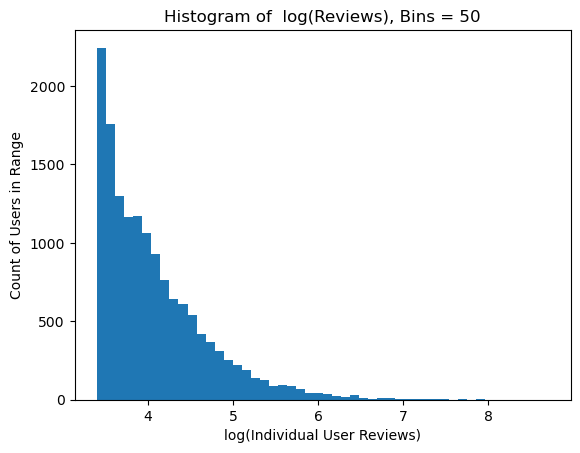

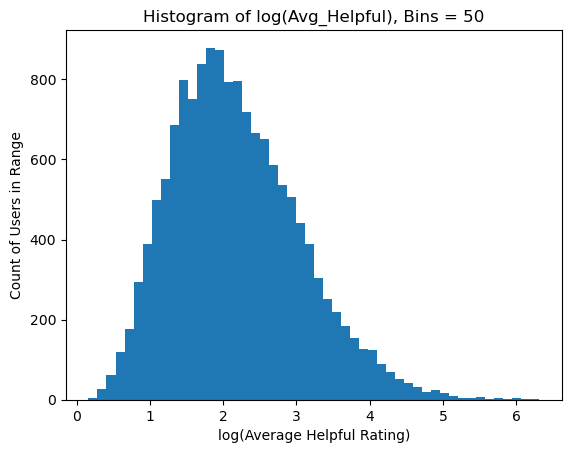

In [30]:
plt.hist(transformed_user_info["reviews"], 50)
plt.title("Histogram of  log(Reviews), Bins = 50")
plt.xlabel("log(Individual User Reviews)")
plt.ylabel("Count of Users in Range")
plt.show()
plt.hist(transformed_user_info["avg_helpful"], 50)
plt.title("Histogram of log(Avg_Helpful), Bins = 50")
plt.xlabel("log(Average Helpful Rating)")
plt.ylabel("Count of Users in Range")
plt.show()

## Step 4: Clustering our data

### Why HDBSCAN

Now it is time to discuss why HDBSCAN was chosen as the clustering algorithm. In essence, it is one of the few algorithms that is scale invariant and robust to variable density. Unlike DBSCAN, which also uses a density-based approach to finding clusters, HDBSCAN doesn't require a strict epsilon value that determines whether a point can belong to a cluster or not - it instead starts by looking for the **min_samples** nearest neighbors of each point, regardless of how far those neighbors are. 

For our data, what this means is that even the points in less dense areas have potential to be part of a cluster, without necessarily being "sucked into" the clusters that form closer to the origin. HDBSCAN does still remove points from clusters if they aren't close enough, so many points will remain unclustered, but the points we are interested in (high **reviews**, high **avg_helpful**) stand a much better chance than with purely distance based algorithms.


#### A note on non-Euclidean metrics
While it was not included in the analysis, sklearn's implementation of HDBSCAN was also convenient for readily allowing different choices of metric to be used out of the box - I did in fact experiment with several non-Euclidean metrics. Of particular note was Mahalanobis distance, which consistently outperformed Euclidean distance on untransformed data of all dimensions. However, for the clustering I'm showing in this notebook, I will only use the Euclidean metric.


### Creating User Defined Helper Functions

#### Finding the Best Clusters

To get HDBSCAN to reliably pick up the low-density points we are interested in, we will have to increase its sensitivity to a relatively high level, meaning both **min_samples** and **min_cluster_size** need to be set small. This results in many smaller clusters being formed. However, then we have a new problem - how do we know which clusters best represent our "Elite Reviewers"? 

To solve this, I developed a simple alogrithm that will rule out any clusters that are suboptimal for our criteria.

The basic idea is that we are trying to optimize our two most important metrics- quantity of reviews (**reviews**) and quality of reviews (**avg_helpful**). If one cluster is lower in both of these categories compared to another, then we consider it strictly inferior and do not want to consider those users. So we iterate through each cluster and only keep a cluster if it is superior to another in at least one category. 

Below is a helper function implementing this approach:


In [31]:

# A function to remove any clusters that have both lower reviews and avg_helpful than another cluster - the result is a set of clusters that are pairwise superior in one metric, 
# but not the other.

def find_best_clusters(cluster_info):
    #current_best_overall represents the cluster # that, so far, has the highest reviews and avg_helpful of all clusters
    current_best_overall = 0

    #partial_best_overall represents clusters that are better than current_best_overall in either reviews or avg_helpful, but not both.
    partial_best_overall  = []

    # We iterate across the clusters in cluster_info
    for cluster in cluster_info.index:
        # Exclude unclustered users
        if cluster == -1:
            continue

        #If the cluster has both the highest reviews and highest avg_helpful of any cluster so far, we immediately identify it as our current_best_overall
        if ((cluster_info.loc[cluster, "reviews"].item() > cluster_info.loc[current_best_overall, "reviews"].item()) & (cluster_info.loc[cluster, "avg_helpful"].item() > cluster_info.loc[current_best_overall, "avg_helpful"].item())):
            
            #We also check to see if it has both higher reviews and avg_helpful than our other clusters which had at least one metric greater than the former best overall. If any of them are lower in both criteria, we remove them
            for int in partial_best_overall:
                if ((cluster_info.loc[int, "reviews"].item() <= cluster_info.loc[cluster, "reviews"].item()) & (cluster_info.loc[int, "avg_helpful"].item() <= cluster_info.loc[cluster, "avg_helpful"].item())):
                    partial_best_overall.remove(int)
            current_best_overall = cluster
        #If the cluster has either reviews or avg_helpful greater than our current_best_overall, then we need to check if it is strictly superior to any of our other clusters    
        elif (cluster_info.loc[cluster, "reviews"].item() > cluster_info.loc[current_best_overall, "reviews"].item()) | (cluster_info.loc[cluster, "avg_helpful"].item() > cluster_info.loc[current_best_overall, "avg_helpful"].item()):
            
            #We use the did_find_better variable to keep track of whether or not the cluster we are looking at has any clusters where at least one of reviews or avg_helpful is greater
            did_find_better = None
            partial_best_overall.append(cluster)
            for int in partial_best_overall:
                #if our new cluster has higher reviews and avg_helpful than a cluster in partial_best_overall, we remove the old cluster
                if (cluster_info.loc[cluster, "reviews"].item() > cluster_info.loc[int, "reviews"].item()) & (cluster_info.loc[cluster, "avg_helpful"].item() > cluster_info.loc[int, "avg_helpful"].item()):
                    partial_best_overall.remove(int)
                
                #if it turns out that the new cluster has both lower reviews and lower avg_helpful than one already in partial_best_overall, then we remove the new cluster from consideration and stop searching
                elif (cluster_info.loc[cluster, "reviews"].item() < cluster_info.loc[int, "reviews"].item()) & (cluster_info.loc[cluster, "avg_helpful"].item() < cluster_info.loc[int, "avg_helpful"].item()):
                    partial_best_overall.remove(cluster)
                    did_find_better = False
                    break

                #skip over the case where we compare the cluster to itself
                elif (int == cluster):
                    pass

                # otherwise, we make note that there is at least one other cluster that has either higher reviews or higher avg_helpful
                else:
                    if did_find_better is None:
                        did_find_better = False
                
            # If we made it through the for loop without assigning did_find_better to False, then we mark it as True - This represents scenario where the cluster has both higher reviews and avg_helpful
            # than all other clusters we've seen so far
            if did_find_better is None:
                did_find_better = True

            # If our cluster is in fact better than all other clusters in partial_best_overall, then it should be our new current_best_overall, and our former current_best_overall gets added to partial_best_overall
            if(did_find_better == True):
                partial_best_overall.append(current_best_overall)
                current_best_overall = cluster

    best_clusters = partial_best_overall
    best_clusters.append(current_best_overall)

    best_clusters = cluster_info[cluster_info.index.isin(best_clusters)]

    print("Current Best Cluster:\n")
    print(current_best_overall, "\n")
    print("Cluster Information:\n")
    print(best_clusters.info())
    print(best_clusters.head())
    return best_clusters






#### Analyzing and visualizing the clusters

Here, we will define some functions to allow us to gather our cluster info and plot the clusters easily. Take note that get_cluster_info returns both a DataFrame of user information with a "cluster" column containing the cluster label for that user, and a DataFrame of aggregated statistics for each cluster.

In [32]:
# Takes the .labels_ attribute of a clustering object and a DataFrame  of user info as parameters, assigns the labels to the user info, and then prints some descriptive stats for the clusters.
def get_cluster_info(cluster_list, users):
    clustered_users = users.assign(cluster=cluster_list)
    print("labels assigned")
    print("Total clusters: " + str(np.max(cluster_list) + 1))

    # Aggregates the clusters and calculates most useful descriptive statistics- take note that the "median_helpful" is the median of the user's medians, not of all reviews in cluster
    cluster_info = clustered_users.groupby("cluster").agg({"user_id":"count", "avg_helpful":"mean", "median_helpful":"median", "products":"mean", "reviews":"mean", "proportion_pos_reviews":"mean", "avg_normalized_playtime":"mean", "visibility_score":"mean"})

    # We sort by the count of user_ids to know how many users are in each cluster
    cluster_info.sort_values(by="user_id", ascending=False, inplace=True)
    
    # We print just the head of the DataFrame to see the largest clusters
    print("Largest clusters are: \n")
    print(cluster_info.head())

    return clustered_users, cluster_info

# Plots our users, coloring datapoints based on cluster membership. Takes a list of users with a "cluster" column as a parameter,
# Optional parameters include cluster_info, a dataframe of aggregated statistics for the clusters themselves, and plot_zero_median and plot_unclustered, which let us decide if we want to plot
# clusters with median_helpful <= 0 or cluster=-1 (unclustered), respectively. 
def plot_clusters(clustered_users, cluster_info=None, plot_zero_median=True, plot_unclustered=False):
    # If cluster info was not provided, we aggregate it now
    if ((cluster_info is None) and ((plot_zero_median == False) or (plot_unclustered == False))):
        cluster_info = clustered_users.groupby("cluster").agg({"user_id":"count", "avg_helpful":"mean", "median_helpful":"median", "products":"mean", "reviews":"mean", "proportion_pos_reviews":"mean"})
    
    # Temporarily set clusters_to_plot to be cluster_info so we can filter if needed
    clusters_to_plot = cluster_info
    if not plot_unclustered:
        #Remove clusters for which cluster == -1, representing unclustered points
        clusters_to_plot = clusters_to_plot[(cluster_info.index != -1)]
    if not plot_zero_median:
        # Remove clusters for which median_helpful <= 0
        clusters_to_plot = clusters_to_plot[clusters_to_plot["median_helpful"] > 0]
    
    #We plot users whose cluster remains in clusters_to_plot
    users_to_plot = clustered_users[clustered_users["cluster"].isin(clusters_to_plot.index)]
    sns.relplot(x="reviews", y="avg_helpful", kind="scatter", data=users_to_plot, hue="cluster")

    plt.title("reviews vs. avg_helpful")
    #Show the plot
    plt.show()
    return



### Selecting Variables to cluster with

I found that the best results (in terms of optimizing **reviews** and **avg_helpful**) happened by clustering the transformed in two dimensions - **reviews** and **avg_helpful**. 

In [33]:
# Create a DataFrame with only the columns we want to cluster on - Make sure to only use numeric types
transformed_observations = transformed_user_info[["reviews", "avg_helpful"]]

#Remove any NaN values
transformed_observations = transformed_observations.replace(np.nan, 0, regex=True)
print("NaNs replaced")

NaNs replaced


### Executing the HDBSCAN Algorithm

Now, we execute the algorithm. Note the low **min_samples** and **min_cluster_size** values, which make the algorithm more sensitive to sparse clusters. 

Also make note that when creating the **transformed_users_with_clusters** DataFrame, the untransformed data values are used so that the plots reflect the full scope of the data.

labels assigned
Total clusters: 641
Largest clusters are: 

         user_id  avg_helpful  median_helpful     products     reviews  \
cluster                                                                  
-1          3401    17.879152             3.0  1297.493678  102.061453   
 81           59    48.603296            10.0   916.847458   33.864407   
 122          59     3.107345             2.0   688.762712   30.000000   
 626          57     4.811740             2.5   920.421053   61.157895   
 116          54     2.286420             2.0   525.666667   30.000000   

         proportion_pos_reviews  avg_normalized_playtime  visibility_score  
cluster                                                                     
-1                     0.805339                -0.017435      86705.274425  
 81                    0.803783                 0.011537     172122.779567  
 122                   0.835593                -0.027469     140851.390960  
 626                   0.779735     

c:\Users\tdsul\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


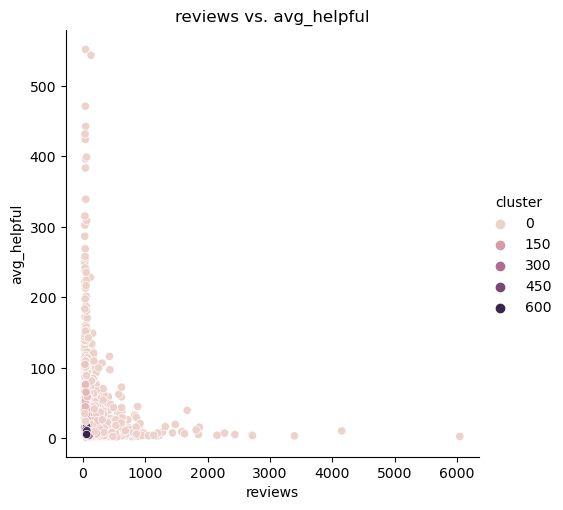

c:\Users\tdsul\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


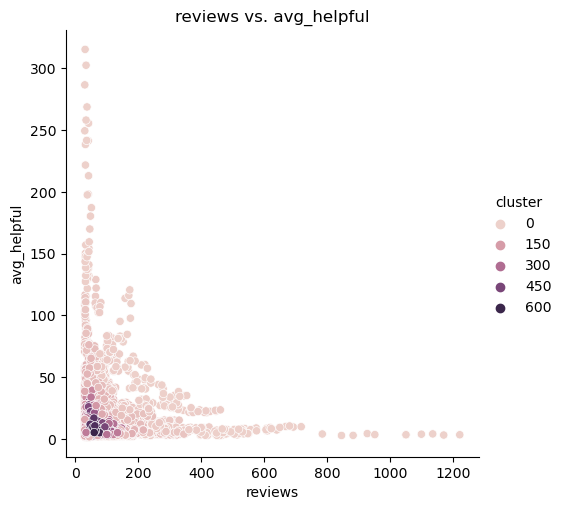

Current Best Cluster:

2 

Cluster Information:

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 8 to 16
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  10 non-null     int64  
 1   avg_helpful              10 non-null     float64
 2   median_helpful           10 non-null     float64
 3   products                 10 non-null     float64
 4   reviews                  10 non-null     float64
 5   proportion_pos_reviews   10 non-null     float64
 6   avg_normalized_playtime  10 non-null     float64
 7   visibility_score         10 non-null     float64
dtypes: float64(7), int64(1)
memory usage: 720.0 bytes
None
         user_id  avg_helpful  median_helpful     products     reviews  \
cluster                                                                  
8             28   144.459022           23.25  1782.321429   38.357143   
4             28    42.117021   

c:\Users\tdsul\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


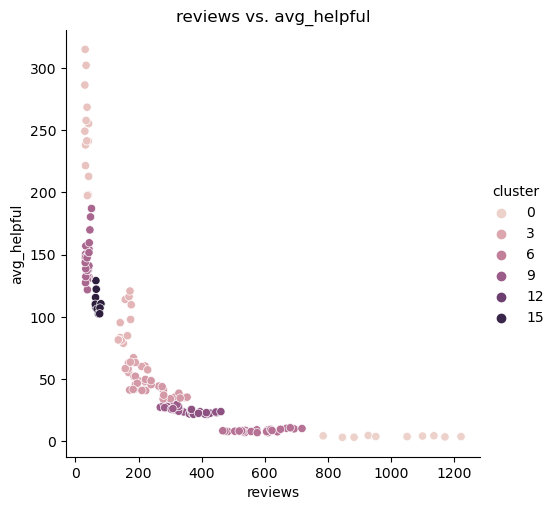

c:\Users\tdsul\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


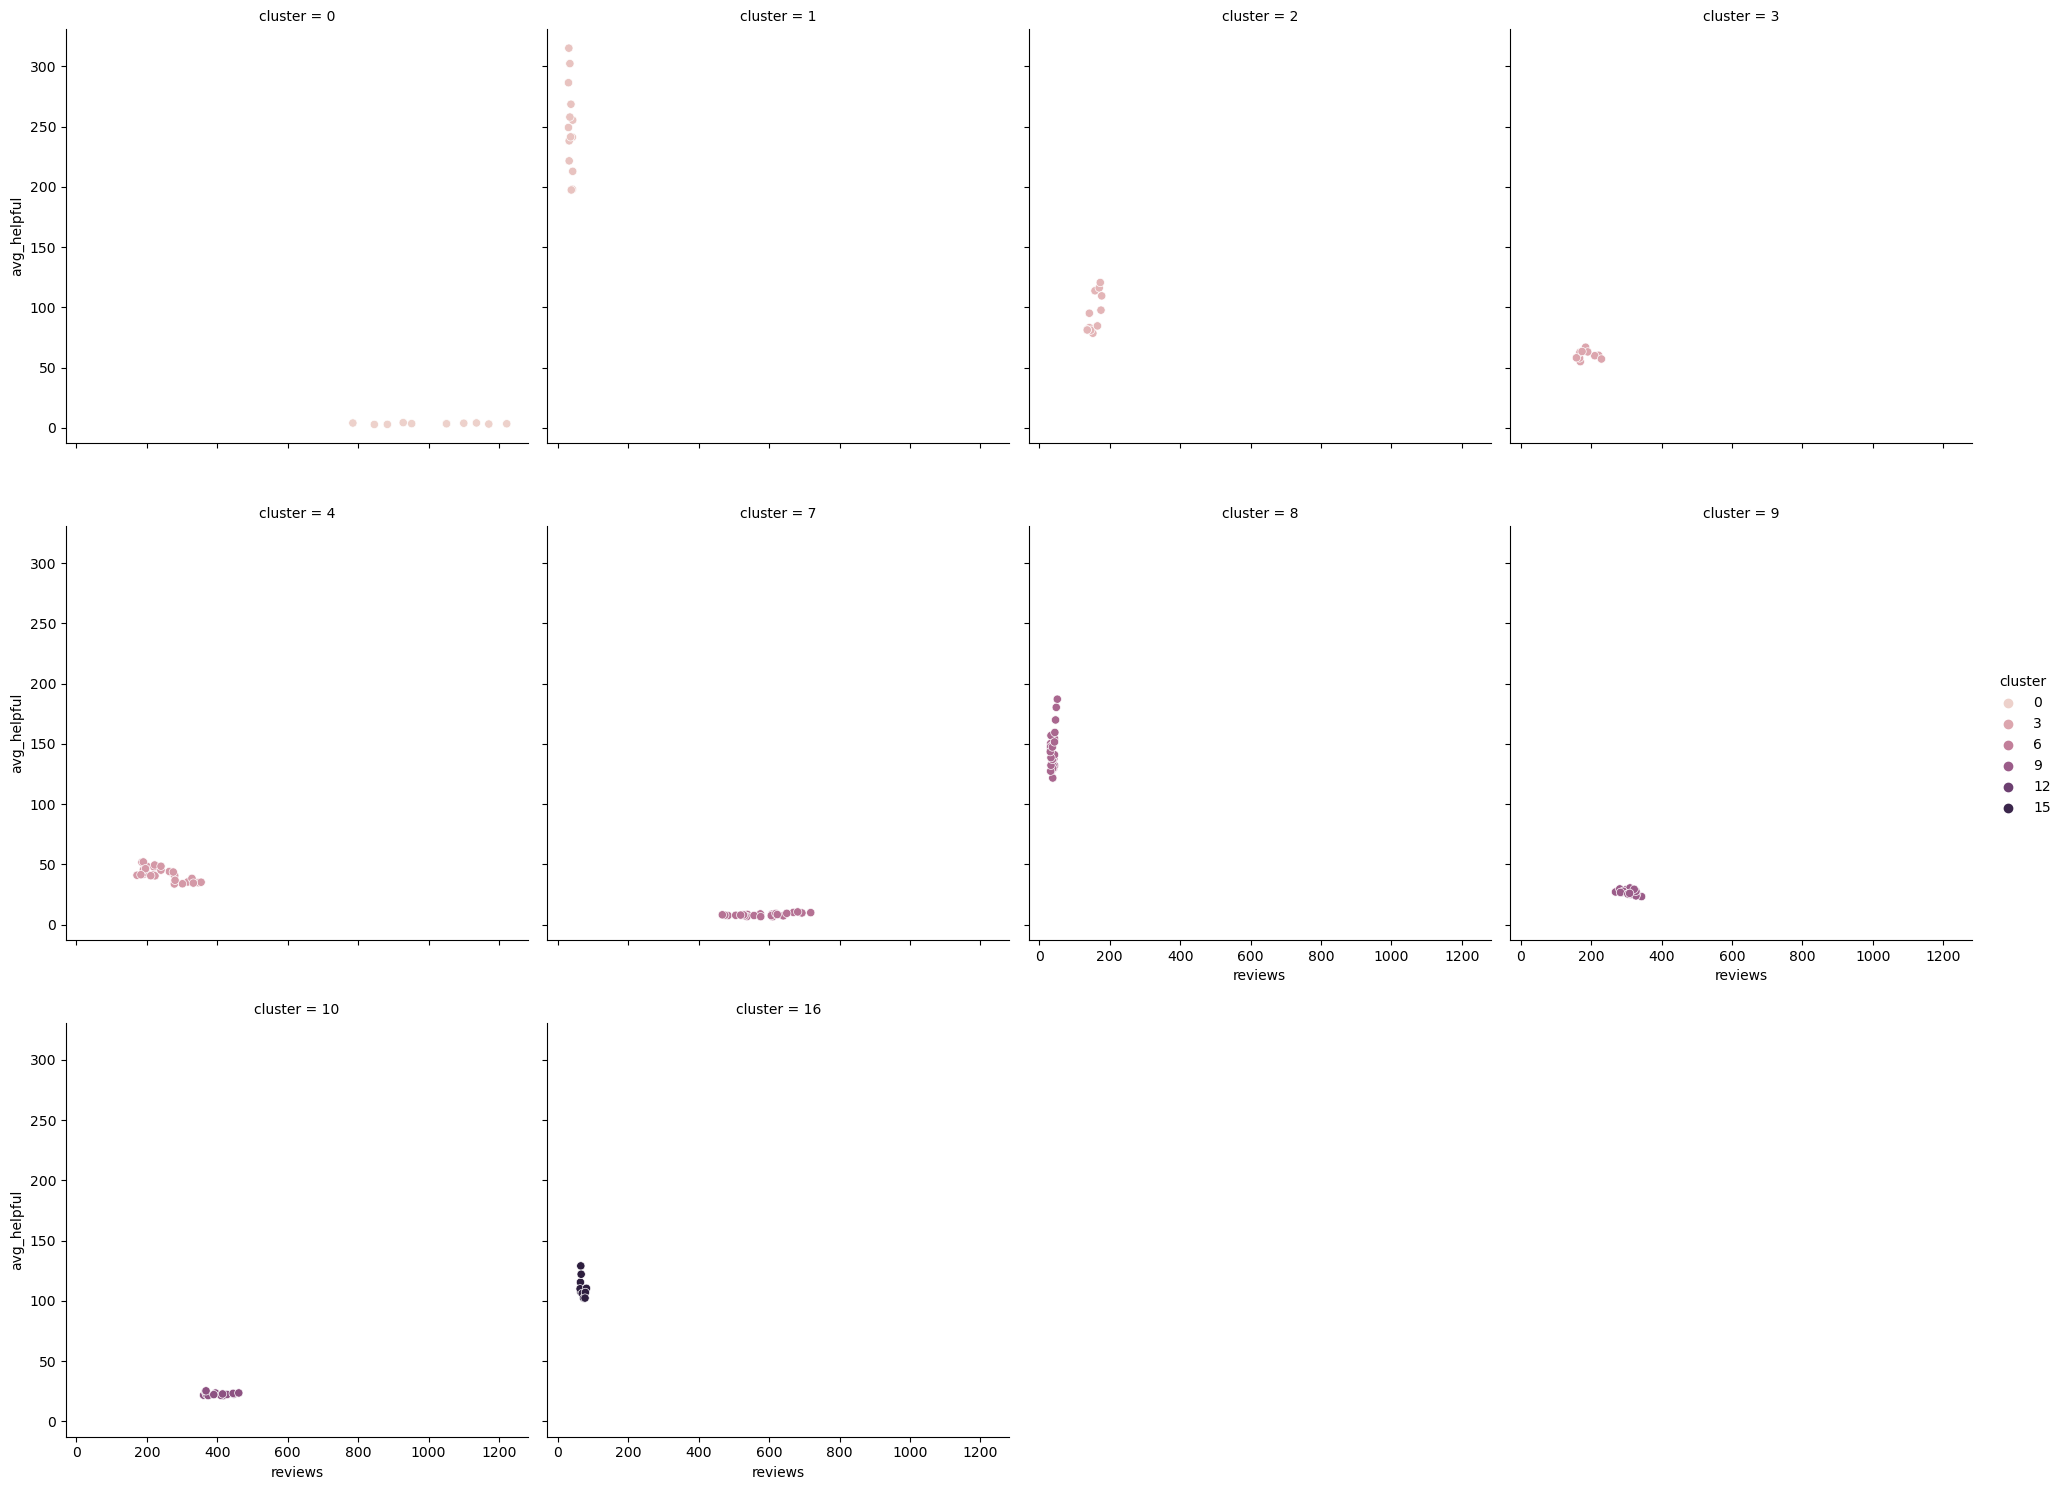

In [41]:
# We create a cluster object with desired parameters
clustering = HDBSCAN(min_cluster_size=10,  min_samples=2, metric="euclidean", cluster_selection_method="leaf")
#Pass in our observations
clustering.fit(transformed_observations)

#Use cluster labels to create info for both users and clusters
transformed_users_with_clusters, transformed_agg_info = get_cluster_info(clustering.labels_, final_user_info)

#We make one plot showing all the unclustered points so we can see what the algorithm missed
plot_clusters(transformed_users_with_clusters, cluster_info=transformed_agg_info, plot_unclustered=True)

#We make a second plot of only clustered points, to better see shape of data
plot_clusters(transformed_users_with_clusters, cluster_info=transformed_agg_info)

#If we have a small number of clusters, we will just plot them all individually
if max(clustering.labels_) < 7:
    sns.relplot(x="reviews", y="avg_helpful", kind="scatter", data=transformed_users_with_clusters, col="cluster", hue="cluster")


# We run our algorithm to find our best clusters
best_clusters = find_best_clusters(transformed_agg_info)

# Make a DataFrame of only users in one of the best clusters
users_in_best_clusters = transformed_users_with_clusters[transformed_users_with_clusters["cluster"].isin(best_clusters.index)]

# print the DataFrame so we can see the cluster's stats
print("Number of Clusters of Interest:\n")
print(best_clusters)

# plot the best clusters so we can see them
plot_clusters(users_in_best_clusters, cluster_info=best_clusters)

#Plot the best clusters individually 
sns.relplot(x="reviews", y="avg_helpful", kind="scatter", data=users_in_best_clusters, col="cluster", hue="cluster", col_wrap=4)
plt.subplots_adjust(hspace=0.2)

## Step 5: Analysis of Clusters

Now that we have a set of clusters, we can delve deeper into its properties! First, lets get a sense of how many users are included in these clusters:

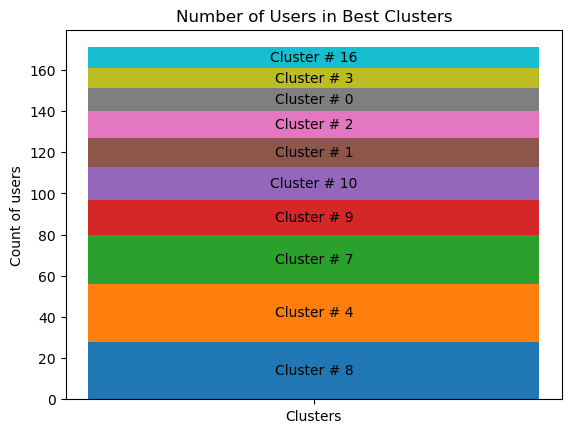

In [35]:
x = 0
for cluster in best_clusters.index:
    
    bar_container = plt.bar("Clusters", best_clusters.loc[cluster, "user_id"], bottom= x)
    plt.bar_label(bar_container, labels=["Cluster # " + str(cluster)], label_type="center")

    x += best_clusters.loc[cluster, "user_id"]
plt.ylabel("Count of users")
plt.title("Number of Users in Best Clusters")
plt.show()

Rougly 170 unique users are in these clusters. That is < 1% of our filtered set of users, which itself was only a fraction of all Steam Users! By any standard, this group of highly selective, making it a great choice for piloting the "Elite Reviewers" program. 

However, the downside of HDBSCAN's approach is apparent - these clusters are individually on the small side, which makes it hard to generalize insights from them to the whole dataset. 

One option to help alleviate this is to manually merge some of the clusters together (it would seem that  {1,8,16}, {0,7}, and {2,3,4,9} could be good choices). For purposes of demonstration, I will proceed with analyzing the clusters without merging them. 


### Correlation analysis

Recall that we only applied our clustering algorithm to two variables, **reviews** and **avg_helpful.** By design, our clustering algorithm has identified the users that are similar to each other by these metrics. We would like to know if, in the process, we also uncovered similarities among other variables. To give us an idea of what we might see, below is a correlation matrix for some variables of interest.

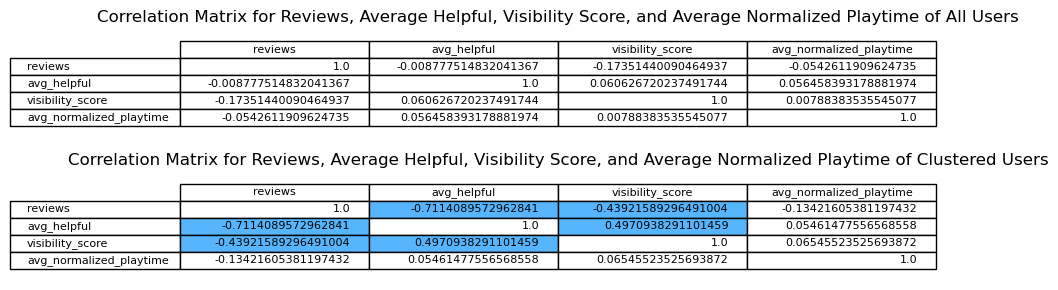

In [42]:

fig, ax = plt.subplots(2)
fig.patch.set_visible(False)

ax[0].axis('off')
ax[0].axis('tight')
ax[0].set_title("Correlation Matrix for Reviews, Average Helpful, Visibility Score, and Average Normalized Playtime of All Users")
ax[0].title.set_color("black")
ax[1].axis('off')
ax[1].axis('tight')
ax[1].set_title("Correlation Matrix for Reviews, Average Helpful, Visibility Score, and Average Normalized Playtime of Clustered Users")
ax[1].title.set_color("black")
fig.set_figheight(3)
fig.set_figwidth(10)
cell_text1 =[]
cell_text2 = []
colors = [["w","#56b5fd", "#56b5fd", "w"], ["#56b5fd", "w", "#56b5fd", "w"], ["#56b5fd", "#56b5fd", "w", "w"], ["w", "w", "w", "w"]]

unclustered_corr_matrix = pd.DataFrame(final_user_info[["reviews", "avg_helpful", "visibility_score", "avg_normalized_playtime"]].corr())
clustered_corr_matrix = pd.DataFrame(users_in_best_clusters[["reviews", "avg_helpful", "visibility_score", "avg_normalized_playtime"]].corr())

for i in unclustered_corr_matrix.index:
    cell_text1.append(list(map(str, unclustered_corr_matrix.loc[i])))
    cell_text2.append(list(map(str, clustered_corr_matrix.loc[i])))
ax[0].table(cellText=unclustered_corr_matrix.values, rowLabels=unclustered_corr_matrix.index, colLabels=unclustered_corr_matrix.columns, loc='center')
ax[1].table(cellText=clustered_corr_matrix.values, rowLabels=clustered_corr_matrix.index, colLabels=clustered_corr_matrix.columns, loc='center', cellColours=colors)

fig.tight_layout()

Notice how the correlations for the unclustered users are generally very low, but the correlations for the clustered users are much greater. There are three correlations in particular that stand out: 
* the correlation between **reviews** and **avg_helpful**
* the correlation between **reviews** and **visibility_score** 
* the correlation between **avg_helpful** and **visibility_score** 

The correlation between **reviews** and **avg_helpful** is partially expected behavior as a result of our algorithm which sought to optimize these two things. However, the correlations involving **visibility_score** are unexpected - recall that we did NOT cluster based on **visibility_score** so we would not immediately expect our clusters to have some relationship to it. This hints at a more nuanced connection than can be seen at the global scale. 

Let's plot out the relationship between **avg_helpful** and **visibility_score** for both clustered and unclustered users, to get a sense of how the difference manifests.

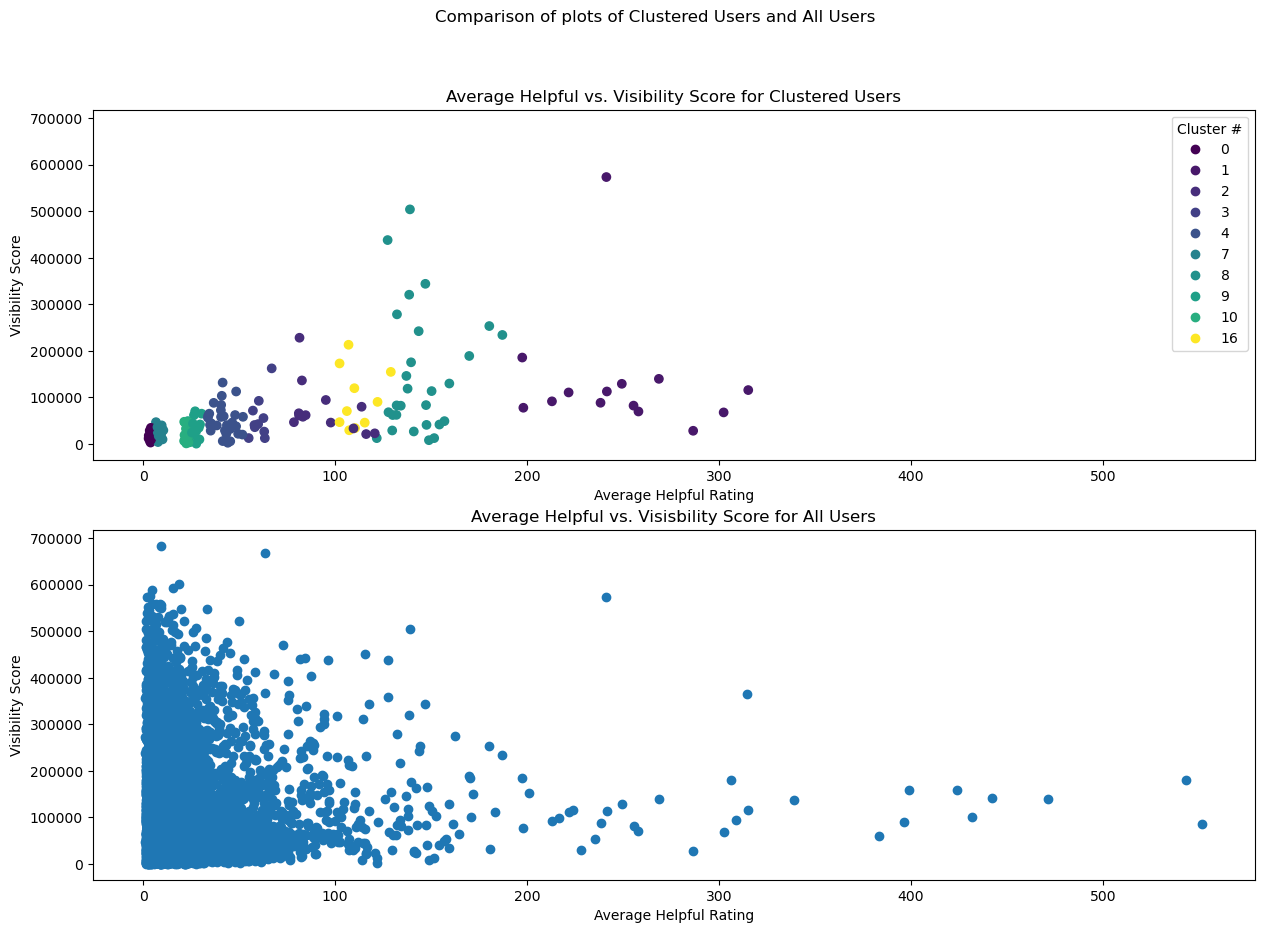

In [37]:


fig, ax = plt.subplots(2)
fig.set_figwidth(15)
fig.set_figheight(10)
fig.suptitle("Comparison of plots of Clustered Users and All Users")

                

            

ax[0].set_title("Best Clusters Data")
legend_scatter = ax[0].scatter(users_in_best_clusters["avg_helpful"], users_in_best_clusters["visibility_score"], c=users_in_best_clusters["cluster"])
ax[0].set_xlabel("Average Helpful Rating")
ax[0].set_ylabel("Visibility Score")
ax[0].set_title("Average Helpful vs. Visibility Score for Clustered Users")
ax[0].legend(*legend_scatter.legend_elements(num=None), title="Cluster #")


ax[1].set_title("Average Helpful vs. Visibility Score for Unclustered Users")
ax[1].scatter(final_user_info["avg_helpful"], final_user_info["visibility_score"])
ax[1].set_xlabel("Average Helpful Rating")
ax[1].set_ylabel("Visibility Score")
ax[1].set_title("Average Helpful vs. Visisbility Score for All Users")


for i in range(2):        
    if i % 2 == 0:
            ax[i].set_xlim(ax[1].get_xlim())
            ax[i].set_ylim(ax[1].get_ylim())

plt.show()

Notice how the clusters occupy mostly fixed, non-overlapping ranges in the horizontal axis. If you compare each horizontal range in the plots on the left with the corresponding range in the plots on the right, you can see that there are some ranges on the right whose interior points are more dispersed than on the left. This is most obvious where the horizontal axis approaches 0; consider the following graph:  

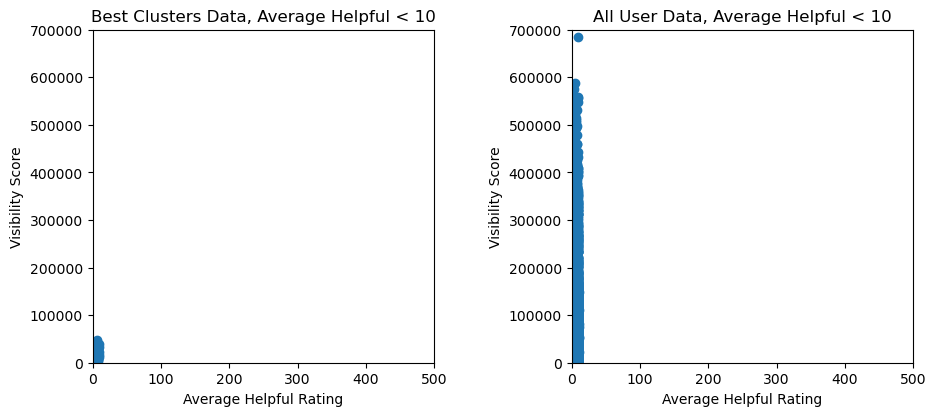

In [38]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(10)
ax[0].set_title("Best Clusters Data, Average Helpful < 10")
ax[0].set_xlabel("Average Helpful Rating")
ax[0].set_ylabel("Visibility Score")
ax[0].set_xlim((0,500))
ax[0].set_ylim((0,700000))
ax[0].scatter(users_in_best_clusters[users_in_best_clusters["avg_helpful"] < 10]["avg_helpful"], users_in_best_clusters[users_in_best_clusters["avg_helpful"] < 10]["visibility_score"])
ax[1].scatter(final_user_info[final_user_info["avg_helpful"] < 10]["avg_helpful"], final_user_info[final_user_info["avg_helpful"] < 10]["visibility_score"])
ax[1].set_title("All User Data, Average Helpful < 10")
ax[1].set_xlabel("Average Helpful Rating")
ax[1].set_ylabel("Visibility Score")
ax[1].set_xlim((0,500))
ax[1].set_ylim((0,700000))

fig.tight_layout(pad = 3)
plt.show()

The clustered points with the lowest Average Helpful rating have Visibility Scores roughly between 0 and 50000. However, the unclustered points in the same range of Average Helpful Rating have Visibility scores as high as 600000! 

This suggests that the variance of **visibility_score** for all users in this range of **avg_helpful** is much greater than the variance of clustered users in the same range of **avg_helpful**. Let's confirm this by calculating the variance in **visibility score** for each cluster, and comparing with the variance of **visibility score** in the same range of **avg_helpful**.

[]

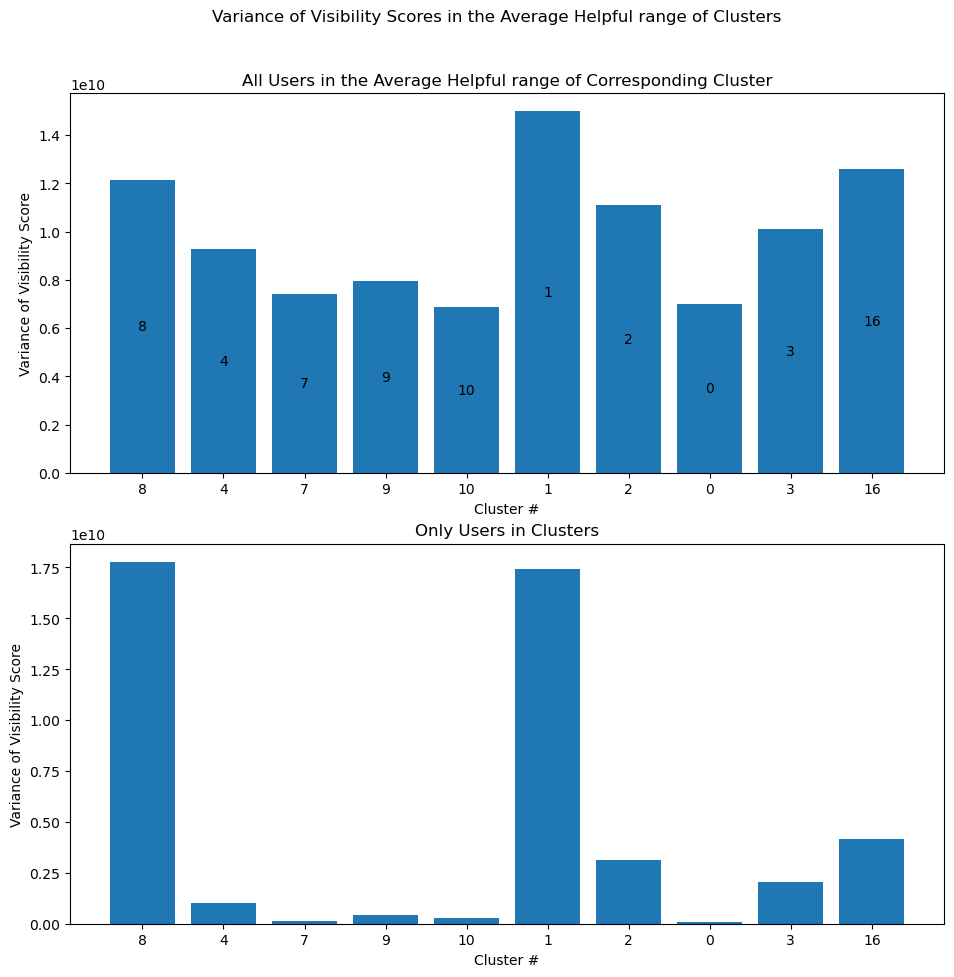

In [39]:


bar_list1 = []
bar_list2 = []


for cluster in best_clusters.index:
    # we define how to restrict the unclustered data based on the max and min of the clustered data
    variance_visibility = final_user_info[(final_user_info["avg_helpful"] <= users_in_best_clusters[users_in_best_clusters["cluster"] == cluster]["avg_helpful"].max()) & (final_user_info["avg_helpful"] > users_in_best_clusters[users_in_best_clusters["cluster"] == cluster]["avg_helpful"].min())]["visibility_score"].var()

    variance_cluster_visibility = users_in_best_clusters[users_in_best_clusters["cluster"] == cluster]["visibility_score"].var()
    bar_list1.append(variance_visibility)
    bar_list2.append(variance_cluster_visibility)

#Create bar plots
fig, ax = plt.subplots(2)
fig.set_figwidth(10)
fig.set_figheight(10)
fig.suptitle("Variance of Visibility Scores in the Average Helpful range of Clusters")
fig.tight_layout(pad=3)
bar_container1 = ax[0].bar(list(map(str, best_clusters.index)), bar_list1)
plt.bar_label(bar_container1, labels=best_clusters.index, label_type="center")
ax[0].set_ylabel("Variance of Visibility Score")
ax[0].set_xlabel("Cluster #")
ax[0].set_title("All Users in the Average Helpful range of Corresponding Cluster")
bar_container2 = ax[1].bar(list(map(str, best_clusters.index)), bar_list2)
#plt.bar_label(bar_container2, labels=best_clusters.index, label_type="center")
ax[1].set_xlabel("Cluster #")
ax[1].set_ylabel("Variance of Visibility Score")
ax[1].set_title("Only Users in Clusters")
plt.plot()

Sure enough, for most of the clusters, the variance has decreased dramatically compared to unclustered users with similar **avg_helpful** scores. This suggests that when it comes to users we are considering for "Elite" status, **visibility_score** may hold more saliency than initially realized at first. This could prove useful for future analyses, making it a factor we should keep track of.

## Conclusion

Let's review the goals and constraints that were established earlier, and evaluate whether we accomplished them or not:

#### Goals:

* We want our "Elite" reviewers to write ***high quality reviews***, so that "Elite" status will be appreciated by both the reviewers and users reading the reviews (we will define how we measure quality later).

* We want our "Elite" reviewers to write ***a high quantity of reviews***, so that their reviews populate the platform quickly.

Our clusters seem to embody these qualities quite well - they sit very close to the "saddle point" that was evident in our raw data, showing that there aren't many users who have a better balance of these two qualities.

* We want to leave the door open to ***analyzing other common factors of high quality reviewers,*** so we can further develop an understanding of how users interact with the feature.

In addition to aggregating several new statistics, such as **proprotion_pos_reviews**, **avg_normalized_playtime**, and **visibility_score**, we identified that **visibility_score** could have a much stronger relationship with reviewers we want to classify as "Elite" than is apparent from the global data - a surprising result, seeing as it wasn't one of the variables we based our clusters on. Furthermore, the 10 distinct, yet internally homogeneous clusters can be individually tracked going forward, so we can even better

#### Constraints:
* "Elite Reviewers" need to be ***active users and writers of reviews.*** - a reviewer does us no good if they are not writing anymore.

* There should be a ***minimum threshold of reviews*** for a user to be considered for this feature.

* "Elite Reviewers" should ***write high quality reviews > 50% of the time.*** 

We were able to satisfy both of these in the data filtration process, so all users in our clusters are guaranteed to satisfy these constraints!

* Since this is the platform's first time with an "Elite Reviewer" program, we want to ***pilot it with a small number of users*** before scaling up. To do this, we want to ensure that we are only giving this distinction to < 1% of the review writing population.

After filtering, our eligible review users numbered was roughly 17,000, and there are about 170 users in our clusters, neatly coming out to just under 1%! Considering that there are over 100,000 review writing users total, we have exceeded our selectivity requirement by any standard imaginable. This small number is ideal for a "soft launch" that will give an opportunity to evaluate the effects of such a feature.


In summary, our approach seems successful in both our subjective and objective metrics of success, and shows the potential of algorithmic clustering to reveal unanticpated connections in our data. 

#### Saving our data

If one would like to analyze this data further, all one needs to do is run the following script to save any newly created data in CSV files:

In [40]:
# only users in our Best Clusters:

users_in_best_clusters.to_csv("users_in_best_clusters.csv")

# all users, with cluster #s attached in "cluster" column:

transformed_users_with_clusters.to_csv("users_with_clusters.csv")

# Aggregated cluster info

transformed_agg_info.to_csv("cluster_info.csv")

# games with average playtime

games_with_avg_hours.to_csv("games_with_avg_hours.csv")

# recs with average and normalized hours played

recs_with_avg_hours.to_csv("recs_with_avg_hours.csv")
